# IMAGE SEGMENTATION

0.60939 (early stopping)

test dice loss 0,68

0.60600 normalization

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os
import PIL

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline
#!pip install -U tensorflow-addons
#!pip install livelossplot
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
#from skimage import io
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
#from tensorflow_addons.layers import GroupNormalization
from sklearn.preprocessing import MinMaxScaler


In [2]:
print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.7.0


Checking the available CPU and GPU devices

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Initial Preparation

### Train data

Setting the path to train images and masks.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
train_x_loc = "../../data/train_images/"
train_y_loc = "../../data/train_masks/"

Extract the names of the image files and sort and store them in a list. This will later be iterated over to read and store the image and mask data.

In [6]:
img_names = [s[:-4] for s in os.listdir(train_x_loc)]

In order to prevent clogging up the RAM, we will create batches of images.

In [7]:
TRAIN_BATCH_SIZE = 87

In [8]:
img_names_batches = [img_names[i:i + TRAIN_BATCH_SIZE] for i in range(0, len(img_names), TRAIN_BATCH_SIZE)]
print("Train images were split into batches of size {}.".format(TRAIN_BATCH_SIZE))
print("Number of batches = ",len(img_names_batches))

Train images were split into batches of size 87.
Number of batches =  3


### Image Configs

In [26]:
INPUT_SIZE = 512
N_CHANNEL = 3
N_CLASSES = 25

## Model Creation

### UNet

In [27]:
def get_unet():
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model
    
def get_unet2(): #testing groupNormalization
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    #conv1 = GroupNormalization(groups=4,axis=2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    #conv2 = GroupNormalization(groups=4)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    #conv3 = GroupNormalization(groups=4)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    #conv4 = GroupNormalization(groups=4)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

In semantic segmentation, you need as many masks as you have object classes. 
In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
certain class - 0 to 26. The correct class is the one with the highest probability. 

Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
lots of classes and to perform pixel-wise multiclass prediction. 

## Training the model

### Creating CallBacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [28]:
# TensorBoard visuluaziations
# To visualize, execute the following commands in a new jupyter notebook:
# %load_ext tensorboard
# %tensorboard --logdir /tmp/tboard_logs8
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('\nTraining: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('\nTraining: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('\nEvaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('\nEvaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

#Other callbacks
early_stopping = EarlyStopping(monitor="accuracy",patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

Defining Loss

In [29]:
import keras.losses 
from keras.metrics import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)= sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.Ref: https://en.wikipedia.org/wiki/Jaccard_index
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.cast(y_pred > t, tf.int32) #tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

keras.losses.custom_objects = bce_dice_loss
# keras.api._v2.keras.metrics.custom_objects = mean_iou

# tf.keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss
# tf.keras.utils.get_custom_objects()['mean_iou'] = mean_iou

### Training

In [30]:
# img_names_batches = [img_names_batches[0]]

In [31]:
for i, imgnames in enumerate(img_names_batches):
    print(i, len(imgnames))

0 87
1 87
2 87


In [32]:
from tensorflow.python.keras.metrics import Metric

# Training configs
EPOCHS = 25 #25-100
LEARNING_RATE = 0.0005 #3e-14
TRAINING_SAVE_LOC = "saved_models/training_25/"

model = None
scaler = MinMaxScaler()
train_hist = {}
import random

for b,img_names in enumerate(img_names_batches):
#     if len(img_names) > 90:
#         EPOCHS = 30
#         print("EPOCHS set to ", EPOCHS)
#     elif len(img_names) < 70:
#         EPOCHS = 5
#         print("EPOCHS set to ", EPOCHS)
#     else:
#         EPOCHS = 20
#         print("EPOCHS set to ", EPOCHS)
    
    # Setting the model
    if model is None:
        print("No model set. Creating new model.")
        model = get_unet()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss= bce_dice_loss, metrics=[bce_dice_loss]) #loss =tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        INITIAL_TRAIN = False
        print("UNet model created from scratch.")
    # else:
    #      model = tf.keras.models.load_model(TRAINING_SAVE_LOC + "batch_" + str(b - 1) + "/", custom_objects={"CustomModel": mean_iou})
    #      print("UNet model loaded from ", TRAINING_SAVE_LOC + "batch_" + str(b - 1) + "/") 
    # if model is None:
    #          print("!!! MODEL NOT SET !!!")
    #          break
              
    # Preparing the data
    x = []
    y = []
    print("Reading train data")
    for i in img_names:
        x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255.)
        y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
    x = np.array(x)
    #x_mean = x.mean() #centering pixels
    #x = x - x_mean #centering pixels
    y = np.array(y)
    #flip = random.randint(0, 1)
    #if flip:
    x = np.append(x, [np.fliplr(i) for i in x], axis=0) #data augmentation (flipping)
    y = np.append(y, [np.fliplr(i) for i in y], axis=0) #data augmentation (flipping)

    # Reserve samples for validation
    val_samples = 54
    x_train = x[:-val_samples]
    print("x train ---- ", len(x_train))
    y_train = y[:-val_samples]
    x_val = x[-val_samples:]
    print("x val ---- ", len(x_val))
    y_val = y[-val_samples:]
    del x,y
    print("Train and Validation data created")
    
    # Training the model
    model_history = model.fit(x_train, y_train, batch_size=2, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=True, callbacks=[MyCustomCallback(),tensorboard,model_checkpoint])
    train_hist[b] = model_history
    print("Train hist recorded for batch - ",b)
    #del x_train,y_train,x_val,y_val
    
    # Saving the model
    print("Saving the model")
    BATCH_LOC = "batch_" + str(b) + "/"
    CURRENT_SAVE_LOC = TRAINING_SAVE_LOC + BATCH_LOC
    #model.save(CURRENT_SAVE_LOC)
    #model.save(CURRENT_SAVE_LOC,save_format='h5')
    print("Saved the model at", CURRENT_SAVE_LOC)

    #0.645 com early stopping
    #0.66 sem early stopping
    

No model set. Creating new model.
UNet model created from scratch.
Reading train data
x train ----  120
x val ----  54
Train and Validation data created
Epoch 1/25

Training: batch 0 begins at 21:53:57.940887


2022-01-14 21:53:58.398946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Training: batch 0 ends at 21:53:59.798439
 1/60 [..............................] - ETA: 1:52 - loss: 1.6486 - bce_dice_loss: 1.6486
Training: batch 1 begins at 21:53:59.854557

Training: batch 1 ends at 21:54:00.609359
 2/60 [>.............................] - ETA: 43s - loss: 1.6251 - bce_dice_loss: 1.6251 
Training: batch 2 begins at 21:54:00.613745

Training: batch 2 ends at 21:54:01.385731
 3/60 [>.............................] - ETA: 43s - loss: 1.5971 - bce_dice_loss: 1.5971
Training: batch 3 begins at 21:54:01.389053

Training: batch 3 ends at 21:54:02.171995
 4/60 [=>............................] - ETA: 43s - loss: 1.5740 - bce_dice_loss: 1.5740
Training: batch 4 begins at 21:54:02.176609

Training: batch 4 ends at 21:54:02.925377
 5/60 [=>............................] - ETA: 42s - loss: 1.5774 - bce_dice_loss: 1.5774
Training: batch 5 begins at 21:54:02.929720

Training: batch 5 ends at 21:54:03.673125
 6/60 [==>...........................] - ETA: 41s - loss: 1.5496 - bce_dice

46/60 [======================>.......] - ETA: 10s - loss: 1.1962 - bce_dice_loss: 1.1962
Training: batch 46 begins at 21:54:34.708902

Training: batch 46 ends at 21:54:35.522516
47/60 [======================>.......] - ETA: 10s - loss: 1.1892 - bce_dice_loss: 1.1892
Training: batch 47 begins at 21:54:35.526920

Training: batch 47 ends at 21:54:36.341304
48/60 [=======================>......] - ETA: 9s - loss: 1.1817 - bce_dice_loss: 1.1817 
Training: batch 48 begins at 21:54:36.345492

Training: batch 48 ends at 21:54:37.226805
49/60 [=======================>......] - ETA: 8s - loss: 1.1796 - bce_dice_loss: 1.1796
Training: batch 49 begins at 21:54:37.229774

Training: batch 49 ends at 21:54:38.203129
50/60 [========================>.....] - ETA: 7s - loss: 1.1693 - bce_dice_loss: 1.1693
Training: batch 50 begins at 21:54:38.205991

Training: batch 50 ends at 21:54:39.173869
51/60 [========================>.....] - ETA: 7s - loss: 1.1668 - bce_dice_loss: 1.1668
Training: batch 51 begin

2022-01-14 21:54:47.555312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Evaluating: batch 0 ends at 21:54:47.919986

Evaluating: batch 1 begins at 21:54:47.920968

Evaluating: batch 1 ends at 21:54:48.138740

Evaluating: batch 2 begins at 21:54:48.140114

Evaluating: batch 2 ends at 21:54:48.367054

Evaluating: batch 3 begins at 21:54:48.369097

Evaluating: batch 3 ends at 21:54:48.629392

Evaluating: batch 4 begins at 21:54:48.631733

Evaluating: batch 4 ends at 21:54:48.877126

Evaluating: batch 5 begins at 21:54:48.879664

Evaluating: batch 5 ends at 21:54:49.112787

Evaluating: batch 6 begins at 21:54:49.115401

Evaluating: batch 6 ends at 21:54:49.349168

Evaluating: batch 7 begins at 21:54:49.351233

Evaluating: batch 7 ends at 21:54:49.583497

Evaluating: batch 8 begins at 21:54:49.584920

Evaluating: batch 8 ends at 21:54:49.813062

Evaluating: batch 9 begins at 21:54:49.815283

Evaluating: batch 9 ends at 21:54:50.089052

Evaluating: batch 10 begins at 21:54:50.090637

Evaluating: batch 10 ends at 21:54:50.351119

Evaluating: batch 11 begins at 2

2022-01-14 21:54:54.708354: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./keras.model/assets
60/60 [==============================] - 58s 950ms/step - loss: 1.1398 - bce_dice_loss: 1.1398 - val_loss: 0.9523 - val_bce_dice_loss: 0.9523
Epoch 2/25

Training: batch 0 begins at 21:54:55.920360

Training: batch 0 ends at 21:54:56.747254
 1/60 [..............................] - ETA: 48s - loss: 0.9196 - bce_dice_loss: 0.9196
Training: batch 1 begins at 21:54:56.750998

Training: batch 1 ends at 21:54:57.677420
 2/60 [>.............................] - ETA: 53s - loss: 1.0432 - bce_dice_loss: 1.0432
Training: batch 2 begins at 21:54:57.681910

Training: batch 2 ends at 21:54:58.601989
 3/60 [>.............................] - ETA: 52s - loss: 1.0262 - bce_dice_loss: 1.0262
Training: batch 3 begins at 21:54:58.606618

Training: batch 3 ends at 21:54:59.507277
 4/60 [=>............................] - ETA: 51s - loss: 0.9737 - bce_dice_loss: 0.9737
Training: batch 4 begins at 21:54:59.510007

Training: batch 4 ends at 21:55:00.411878

45/60 [=====================>........] - ETA: 13s - loss: 0.8692 - bce_dice_loss: 0.8692
Training: batch 45 begins at 21:55:35.308013

Training: batch 45 ends at 21:55:36.100863
46/60 [======================>.......] - ETA: 12s - loss: 0.8714 - bce_dice_loss: 0.8714
Training: batch 46 begins at 21:55:36.105456

Training: batch 46 ends at 21:55:36.901115
47/60 [======================>.......] - ETA: 11s - loss: 0.8675 - bce_dice_loss: 0.8675
Training: batch 47 begins at 21:55:36.903669

Training: batch 47 ends at 21:55:37.705031
48/60 [=======================>......] - ETA: 10s - loss: 0.8638 - bce_dice_loss: 0.8638
Training: batch 48 begins at 21:55:37.707849

Training: batch 48 ends at 21:55:38.500201
49/60 [=======================>......] - ETA: 9s - loss: 0.8648 - bce_dice_loss: 0.8648 
Training: batch 49 begins at 21:55:38.504984

Training: batch 49 ends at 21:55:39.299137
50/60 [========================>.....] - ETA: 8s - loss: 0.8654 - bce_dice_loss: 0.8654
Training: batch 50 beg

15/60 [======>.......................] - ETA: 36s - loss: 0.7912 - bce_dice_loss: 0.7912
Training: batch 15 begins at 21:56:07.027528

Training: batch 15 ends at 21:56:07.822462
16/60 [=======>......................] - ETA: 35s - loss: 0.7905 - bce_dice_loss: 0.7905
Training: batch 16 begins at 21:56:07.826811

Training: batch 16 ends at 21:56:08.617078
17/60 [=======>......................] - ETA: 34s - loss: 0.7937 - bce_dice_loss: 0.7937
Training: batch 17 begins at 21:56:08.621427

Training: batch 17 ends at 21:56:09.414059
18/60 [========>.....................] - ETA: 33s - loss: 0.7923 - bce_dice_loss: 0.7923
Training: batch 18 begins at 21:56:09.419926

Training: batch 18 ends at 21:56:10.234264
19/60 [========>.....................] - ETA: 33s - loss: 0.7843 - bce_dice_loss: 0.7843
Training: batch 19 begins at 21:56:10.238740

Training: batch 19 ends at 21:56:11.029797
20/60 [=========>....................] - ETA: 32s - loss: 0.7866 - bce_dice_loss: 0.7866
Training: batch 20 be


Evaluating: batch 1 ends at 21:56:43.587026

Evaluating: batch 2 begins at 21:56:43.588576

Evaluating: batch 2 ends at 21:56:43.805854

Evaluating: batch 3 begins at 21:56:43.809240

Evaluating: batch 3 ends at 21:56:44.029641

Evaluating: batch 4 begins at 21:56:44.032172

Evaluating: batch 4 ends at 21:56:44.251644

Evaluating: batch 5 begins at 21:56:44.254246

Evaluating: batch 5 ends at 21:56:44.475504

Evaluating: batch 6 begins at 21:56:44.477872

Evaluating: batch 6 ends at 21:56:44.697720

Evaluating: batch 7 begins at 21:56:44.700132

Evaluating: batch 7 ends at 21:56:44.920388

Evaluating: batch 8 begins at 21:56:44.922870

Evaluating: batch 8 ends at 21:56:45.142204

Evaluating: batch 9 begins at 21:56:45.144801

Evaluating: batch 9 ends at 21:56:45.366059

Evaluating: batch 10 begins at 21:56:45.368583

Evaluating: batch 10 ends at 21:56:45.589685

Evaluating: batch 11 begins at 21:56:45.592207

Evaluating: batch 11 ends at 21:56:45.812624

Evaluating: batch 12 begins at

32/60 [===============>..............] - ETA: 22s - loss: 0.7727 - bce_dice_loss: 0.7727
Training: batch 32 begins at 21:57:14.814435

Training: batch 32 ends at 21:57:15.615803
33/60 [===============>..............] - ETA: 21s - loss: 0.7750 - bce_dice_loss: 0.7750
Training: batch 33 begins at 21:57:15.619676

Training: batch 33 ends at 21:57:16.400689
34/60 [================>.............] - ETA: 20s - loss: 0.7720 - bce_dice_loss: 0.7720
Training: batch 34 begins at 21:57:16.405675

Training: batch 34 ends at 21:57:17.186743
35/60 [================>.............] - ETA: 19s - loss: 0.7728 - bce_dice_loss: 0.7728
Training: batch 35 begins at 21:57:17.191034

Training: batch 35 ends at 21:57:18.018824
36/60 [=================>............] - ETA: 19s - loss: 0.7722 - bce_dice_loss: 0.7722
Training: batch 36 begins at 21:57:18.025749

Training: batch 36 ends at 21:57:18.810428
37/60 [=================>............] - ETA: 18s - loss: 0.7742 - bce_dice_loss: 0.7742
Training: batch 37 be

 2/60 [>.............................] - ETA: 54s - loss: 0.6721 - bce_dice_loss: 0.6721
Training: batch 2 begins at 21:57:46.809051

Training: batch 2 ends at 21:57:47.707592
 3/60 [>.............................] - ETA: 52s - loss: 0.7366 - bce_dice_loss: 0.7366
Training: batch 3 begins at 21:57:47.712104

Training: batch 3 ends at 21:57:48.608115
 4/60 [=>............................] - ETA: 51s - loss: 0.7105 - bce_dice_loss: 0.7105
Training: batch 4 begins at 21:57:48.611286

Training: batch 4 ends at 21:57:49.444111
 5/60 [=>............................] - ETA: 49s - loss: 0.7451 - bce_dice_loss: 0.7451
Training: batch 5 begins at 21:57:49.448101

Training: batch 5 ends at 21:57:50.290663
 6/60 [==>...........................] - ETA: 47s - loss: 0.7268 - bce_dice_loss: 0.7268
Training: batch 6 begins at 21:57:50.293098

Training: batch 6 ends at 21:57:51.348644
 7/60 [==>...........................] - ETA: 48s - loss: 0.7247 - bce_dice_loss: 0.7247
Training: batch 7 begins at 21:

48/60 [=======================>......] - ETA: 10s - loss: 0.7308 - bce_dice_loss: 0.7308
Training: batch 48 begins at 21:58:25.217205

Training: batch 48 ends at 21:58:26.003476
49/60 [=======================>......] - ETA: 9s - loss: 0.7291 - bce_dice_loss: 0.7291 
Training: batch 49 begins at 21:58:26.007961

Training: batch 49 ends at 21:58:26.821171
50/60 [========================>.....] - ETA: 8s - loss: 0.7277 - bce_dice_loss: 0.7277
Training: batch 50 begins at 21:58:26.825540

Training: batch 50 ends at 21:58:27.622170
51/60 [========================>.....] - ETA: 7s - loss: 0.7298 - bce_dice_loss: 0.7298
Training: batch 51 begins at 21:58:27.626785

Training: batch 51 ends at 21:58:28.423551
52/60 [=========================>....] - ETA: 6s - loss: 0.7291 - bce_dice_loss: 0.7291
Training: batch 52 begins at 21:58:28.427451

Training: batch 52 ends at 21:58:29.217285
53/60 [=========================>....] - ETA: 5s - loss: 0.7304 - bce_dice_loss: 0.7304
Training: batch 53 begins

18/60 [========>.....................] - ETA: 34s - loss: 0.6784 - bce_dice_loss: 0.6784
Training: batch 18 begins at 21:58:57.870539

Training: batch 18 ends at 21:58:58.688532
19/60 [========>.....................] - ETA: 33s - loss: 0.6834 - bce_dice_loss: 0.6834
Training: batch 19 begins at 21:58:58.692897

Training: batch 19 ends at 21:58:59.495995
20/60 [=========>....................] - ETA: 32s - loss: 0.6846 - bce_dice_loss: 0.6846
Training: batch 20 begins at 21:58:59.500256

Training: batch 20 ends at 21:59:00.303552
21/60 [=========>....................] - ETA: 31s - loss: 0.6932 - bce_dice_loss: 0.6932
Training: batch 21 begins at 21:59:00.309226

Training: batch 21 ends at 21:59:01.119792
22/60 [==========>...................] - ETA: 30s - loss: 0.6860 - bce_dice_loss: 0.6860
Training: batch 22 begins at 21:59:01.124274

Training: batch 22 ends at 21:59:01.917055
23/60 [==========>...................] - ETA: 30s - loss: 0.6749 - bce_dice_loss: 0.6749
Training: batch 23 be


Evaluating: batch 7 ends at 21:59:34.922680

Evaluating: batch 8 begins at 21:59:34.923963

Evaluating: batch 8 ends at 21:59:35.143459

Evaluating: batch 9 begins at 21:59:35.145096

Evaluating: batch 9 ends at 21:59:35.365223

Evaluating: batch 10 begins at 21:59:35.366796

Evaluating: batch 10 ends at 21:59:35.592380

Evaluating: batch 11 begins at 21:59:35.593681

Evaluating: batch 11 ends at 21:59:35.819898

Evaluating: batch 12 begins at 21:59:35.822563

Evaluating: batch 12 ends at 21:59:36.044241

Evaluating: batch 13 begins at 21:59:36.045596

Evaluating: batch 13 ends at 21:59:36.272061

Evaluating: batch 14 begins at 21:59:36.274194

Evaluating: batch 14 ends at 21:59:36.506224

Evaluating: batch 15 begins at 21:59:36.507361

Evaluating: batch 15 ends at 21:59:36.728829

Evaluating: batch 16 begins at 21:59:36.730080

Evaluating: batch 16 ends at 21:59:37.028487

Evaluating: batch 17 begins at 21:59:37.029534

Evaluating: batch 17 ends at 21:59:37.245321

Evaluating: batch 

35/60 [================>.............] - ETA: 20s - loss: 0.7171 - bce_dice_loss: 0.7171
Training: batch 35 begins at 22:00:07.864765

Training: batch 35 ends at 22:00:08.661193
36/60 [=================>............] - ETA: 19s - loss: 0.7199 - bce_dice_loss: 0.7199
Training: batch 36 begins at 22:00:08.665517

Training: batch 36 ends at 22:00:09.516921
37/60 [=================>............] - ETA: 18s - loss: 0.7214 - bce_dice_loss: 0.7214
Training: batch 37 begins at 22:00:09.521164

Training: batch 37 ends at 22:00:10.321786
38/60 [==================>...........] - ETA: 17s - loss: 0.7165 - bce_dice_loss: 0.7165
Training: batch 38 begins at 22:00:10.324948

Training: batch 38 ends at 22:00:11.133901
39/60 [==================>...........] - ETA: 17s - loss: 0.7153 - bce_dice_loss: 0.7153
Training: batch 39 begins at 22:00:11.136779

Training: batch 39 ends at 22:00:12.010562
40/60 [===================>..........] - ETA: 16s - loss: 0.7127 - bce_dice_loss: 0.7127
Training: batch 40 be

 5/60 [=>............................] - ETA: 44s - loss: 0.5953 - bce_dice_loss: 0.5953
Training: batch 5 begins at 22:00:39.909547

Training: batch 5 ends at 22:00:40.705945
 6/60 [==>...........................] - ETA: 43s - loss: 0.6406 - bce_dice_loss: 0.6406
Training: batch 6 begins at 22:00:40.709526

Training: batch 6 ends at 22:00:41.513501
 7/60 [==>...........................] - ETA: 42s - loss: 0.6693 - bce_dice_loss: 0.6693
Training: batch 7 begins at 22:00:41.517849

Training: batch 7 ends at 22:00:42.325217
 8/60 [===>..........................] - ETA: 41s - loss: 0.6982 - bce_dice_loss: 0.6982
Training: batch 8 begins at 22:00:42.330172

Training: batch 8 ends at 22:00:43.124838
 9/60 [===>..........................] - ETA: 41s - loss: 0.7102 - bce_dice_loss: 0.7102
Training: batch 9 begins at 22:00:43.128490

Training: batch 9 ends at 22:00:43.950733
10/60 [====>.........................] - ETA: 40s - loss: 0.6963 - bce_dice_loss: 0.6963
Training: batch 10 begins at 22

51/60 [========================>.....] - ETA: 7s - loss: 0.6613 - bce_dice_loss: 0.6613
Training: batch 51 begins at 22:01:16.838837

Training: batch 51 ends at 22:01:17.635236
52/60 [=========================>....] - ETA: 6s - loss: 0.6620 - bce_dice_loss: 0.6620
Training: batch 52 begins at 22:01:17.638945

Training: batch 52 ends at 22:01:18.436892
53/60 [=========================>....] - ETA: 5s - loss: 0.6608 - bce_dice_loss: 0.6608
Training: batch 53 begins at 22:01:18.440476

Training: batch 53 ends at 22:01:19.249942
54/60 [==========================>...] - ETA: 4s - loss: 0.6616 - bce_dice_loss: 0.6616
Training: batch 54 begins at 22:01:19.254769

Training: batch 54 ends at 22:01:20.048638
55/60 [==========================>...] - ETA: 4s - loss: 0.6590 - bce_dice_loss: 0.6590
Training: batch 55 begins at 22:01:20.052888

Training: batch 55 ends at 22:01:20.841295
56/60 [===========================>..] - ETA: 3s - loss: 0.6579 - bce_dice_loss: 0.6579
Training: batch 56 begins a

21/60 [=========>....................] - ETA: 31s - loss: 0.6392 - bce_dice_loss: 0.6392
Training: batch 21 begins at 22:01:48.759020

Training: batch 21 ends at 22:01:49.552608
22/60 [==========>...................] - ETA: 30s - loss: 0.6407 - bce_dice_loss: 0.6407
Training: batch 22 begins at 22:01:49.555253

Training: batch 22 ends at 22:01:50.355544
23/60 [==========>...................] - ETA: 29s - loss: 0.6379 - bce_dice_loss: 0.6379
Training: batch 23 begins at 22:01:50.359695

Training: batch 23 ends at 22:01:51.155445
24/60 [===========>..................] - ETA: 29s - loss: 0.6382 - bce_dice_loss: 0.6382
Training: batch 24 begins at 22:01:51.159657

Training: batch 24 ends at 22:01:51.962342
25/60 [===========>..................] - ETA: 28s - loss: 0.6354 - bce_dice_loss: 0.6354
Training: batch 25 begins at 22:01:51.966759

Training: batch 25 ends at 22:01:52.760715
26/60 [============>.................] - ETA: 27s - loss: 0.6462 - bce_dice_loss: 0.6462
Training: batch 26 be


Evaluating: batch 13 ends at 22:02:23.358732

Evaluating: batch 14 begins at 22:02:23.359942

Evaluating: batch 14 ends at 22:02:23.580341

Evaluating: batch 15 begins at 22:02:23.581870

Evaluating: batch 15 ends at 22:02:23.800806

Evaluating: batch 16 begins at 22:02:23.802416

Evaluating: batch 16 ends at 22:02:24.022113

Evaluating: batch 17 begins at 22:02:24.023718

Evaluating: batch 17 ends at 22:02:24.242892

Evaluating: batch 18 begins at 22:02:24.244092

Evaluating: batch 18 ends at 22:02:24.467712

Evaluating: batch 19 begins at 22:02:24.470681

Evaluating: batch 19 ends at 22:02:24.688893

Evaluating: batch 20 begins at 22:02:24.690471

Evaluating: batch 20 ends at 22:02:24.909002

Evaluating: batch 21 begins at 22:02:24.910286

Evaluating: batch 21 ends at 22:02:25.131532

Evaluating: batch 22 begins at 22:02:25.132908

Evaluating: batch 22 ends at 22:02:25.349185

Evaluating: batch 23 begins at 22:02:25.350428

Evaluating: batch 23 ends at 22:02:25.565101

Evaluating: b

38/60 [==================>...........] - ETA: 17s - loss: 0.6491 - bce_dice_loss: 0.6491
Training: batch 38 begins at 22:02:56.666562

Training: batch 38 ends at 22:02:57.450029
39/60 [==================>...........] - ETA: 16s - loss: 0.6464 - bce_dice_loss: 0.6464
Training: batch 39 begins at 22:02:57.454497

Training: batch 39 ends at 22:02:58.272584
40/60 [===================>..........] - ETA: 16s - loss: 0.6465 - bce_dice_loss: 0.6465
Training: batch 40 begins at 22:02:58.275093

Training: batch 40 ends at 22:02:59.069752
41/60 [===================>..........] - ETA: 15s - loss: 0.6488 - bce_dice_loss: 0.6488
Training: batch 41 begins at 22:02:59.074185

Training: batch 41 ends at 22:02:59.878793
42/60 [====================>.........] - ETA: 14s - loss: 0.6512 - bce_dice_loss: 0.6512
Training: batch 42 begins at 22:02:59.883085

Training: batch 42 ends at 22:03:00.688225
43/60 [====================>.........] - ETA: 13s - loss: 0.6485 - bce_dice_loss: 0.6485
Training: batch 43 be

 9/60 [===>..........................] - ETA: 40s - loss: 0.6364 - bce_dice_loss: 0.6364
Training: batch 9 begins at 22:03:27.601683

Training: batch 9 ends at 22:03:28.405171
10/60 [====>.........................] - ETA: 40s - loss: 0.6359 - bce_dice_loss: 0.6359
Training: batch 10 begins at 22:03:28.408001

Training: batch 10 ends at 22:03:29.204333
11/60 [====>.........................] - ETA: 39s - loss: 0.6307 - bce_dice_loss: 0.6307
Training: batch 11 begins at 22:03:29.207827

Training: batch 11 ends at 22:03:30.005883
12/60 [=====>........................] - ETA: 38s - loss: 0.6385 - bce_dice_loss: 0.6385
Training: batch 12 begins at 22:03:30.009297

Training: batch 12 ends at 22:03:30.800602
13/60 [=====>........................] - ETA: 37s - loss: 0.6296 - bce_dice_loss: 0.6296
Training: batch 13 begins at 22:03:30.803730

Training: batch 13 ends at 22:03:31.593059
14/60 [======>.......................] - ETA: 36s - loss: 0.6359 - bce_dice_loss: 0.6359
Training: batch 14 begi

55/60 [==========================>...] - ETA: 4s - loss: 0.6160 - bce_dice_loss: 0.6160
Training: batch 55 begins at 22:04:05.367369

Training: batch 55 ends at 22:04:06.149532
56/60 [===========================>..] - ETA: 3s - loss: 0.6157 - bce_dice_loss: 0.6157
Training: batch 56 begins at 22:04:06.153737

Training: batch 56 ends at 22:04:06.943209
57/60 [===========================>..] - ETA: 2s - loss: 0.6152 - bce_dice_loss: 0.6152
Training: batch 57 begins at 22:04:06.947332

Training: batch 57 ends at 22:04:07.736405
58/60 [============================>.] - ETA: 1s - loss: 0.6138 - bce_dice_loss: 0.6138
Training: batch 58 begins at 22:04:07.739627

Training: batch 58 ends at 22:04:08.531951
59/60 [============================>.] - ETA: 0s - loss: 0.6148 - bce_dice_loss: 0.6148
Training: batch 59 begins at 22:04:08.536122

Training: batch 59 ends at 22:04:09.358264
60/60 [==============================] - ETA: 0s - loss: 0.6137 - bce_dice_loss: 0.6137
Evaluating: batch 0 begins 

26/60 [============>.................] - ETA: 27s - loss: 0.6379 - bce_dice_loss: 0.6379
Training: batch 26 begins at 22:04:36.192885

Training: batch 26 ends at 22:04:36.991374
27/60 [============>.................] - ETA: 26s - loss: 0.6289 - bce_dice_loss: 0.6289
Training: batch 27 begins at 22:04:36.995443

Training: batch 27 ends at 22:04:37.786469
28/60 [=============>................] - ETA: 25s - loss: 0.6310 - bce_dice_loss: 0.6310
Training: batch 28 begins at 22:04:37.789882

Training: batch 28 ends at 22:04:38.612649
29/60 [=============>................] - ETA: 24s - loss: 0.6271 - bce_dice_loss: 0.6271
Training: batch 29 begins at 22:04:38.619592

Training: batch 29 ends at 22:04:39.410901
30/60 [==============>...............] - ETA: 23s - loss: 0.6278 - bce_dice_loss: 0.6278
Training: batch 30 begins at 22:04:39.415733

Training: batch 30 ends at 22:04:40.205152
31/60 [==============>...............] - ETA: 23s - loss: 0.6272 - bce_dice_loss: 0.6272
Training: batch 31 be


Evaluating: batch 22 ends at 22:05:08.551829

Evaluating: batch 23 begins at 22:05:08.553087

Evaluating: batch 23 ends at 22:05:08.770750

Evaluating: batch 24 begins at 22:05:08.772109

Evaluating: batch 24 ends at 22:05:08.992388

Evaluating: batch 25 begins at 22:05:08.994336

Evaluating: batch 25 ends at 22:05:09.211062

Evaluating: batch 26 begins at 22:05:09.212368

Evaluating: batch 26 ends at 22:05:09.431209

Epoch 00012: val_loss did not improve from 0.60325
60/60 [==============================] - 54s 902ms/step - loss: 0.6292 - bce_dice_loss: 0.6292 - val_loss: 0.6989 - val_bce_dice_loss: 0.6989
Epoch 13/25

Training: batch 0 begins at 22:05:09.462079

Training: batch 0 ends at 22:05:10.260506
 1/60 [..............................] - ETA: 47s - loss: 0.6151 - bce_dice_loss: 0.6151
Training: batch 1 begins at 22:05:10.266111

Training: batch 1 ends at 22:05:11.085869
 2/60 [>.............................] - ETA: 47s - loss: 0.5357 - bce_dice_loss: 0.5357
Training: batch 2 b

43/60 [====================>.........] - ETA: 13s - loss: 0.6010 - bce_dice_loss: 0.6010
Training: batch 43 begins at 22:05:43.926270

Training: batch 43 ends at 22:05:44.713994
44/60 [=====================>........] - ETA: 12s - loss: 0.5982 - bce_dice_loss: 0.5982
Training: batch 44 begins at 22:05:44.717444

Training: batch 44 ends at 22:05:45.534078
45/60 [=====================>........] - ETA: 12s - loss: 0.5956 - bce_dice_loss: 0.5956
Training: batch 45 begins at 22:05:45.537416

Training: batch 45 ends at 22:05:46.328247
46/60 [======================>.......] - ETA: 11s - loss: 0.5952 - bce_dice_loss: 0.5952
Training: batch 46 begins at 22:05:46.333569

Training: batch 46 ends at 22:05:47.123061
47/60 [======================>.......] - ETA: 10s - loss: 0.5963 - bce_dice_loss: 0.5963
Training: batch 47 begins at 22:05:47.127230

Training: batch 47 ends at 22:05:47.920531
48/60 [=======================>......] - ETA: 9s - loss: 0.5950 - bce_dice_loss: 0.5950 
Training: batch 48 be

13/60 [=====>........................] - ETA: 37s - loss: 0.5262 - bce_dice_loss: 0.5262
Training: batch 13 begins at 22:06:15.743611

Training: batch 13 ends at 22:06:16.539201
14/60 [======>.......................] - ETA: 36s - loss: 0.5495 - bce_dice_loss: 0.5495
Training: batch 14 begins at 22:06:16.543371

Training: batch 14 ends at 22:06:17.357300
15/60 [======>.......................] - ETA: 36s - loss: 0.5545 - bce_dice_loss: 0.5545
Training: batch 15 begins at 22:06:17.360587

Training: batch 15 ends at 22:06:18.180118
16/60 [=======>......................] - ETA: 35s - loss: 0.5540 - bce_dice_loss: 0.5540
Training: batch 16 begins at 22:06:18.182589

Training: batch 16 ends at 22:06:19.020854
17/60 [=======>......................] - ETA: 34s - loss: 0.5519 - bce_dice_loss: 0.5519
Training: batch 17 begins at 22:06:19.024870

Training: batch 17 ends at 22:06:19.819631
18/60 [========>.....................] - ETA: 33s - loss: 0.5542 - bce_dice_loss: 0.5542
Training: batch 18 be

59/60 [============================>.] - ETA: 0s - loss: 0.5723 - bce_dice_loss: 0.5723
Training: batch 59 begins at 22:06:52.738623

Training: batch 59 ends at 22:06:53.528637
60/60 [==============================] - ETA: 0s - loss: 0.5710 - bce_dice_loss: 0.5710
Evaluating: batch 0 begins at 22:06:53.563275

Evaluating: batch 0 ends at 22:06:53.833424

Evaluating: batch 1 begins at 22:06:53.834843

Evaluating: batch 1 ends at 22:06:54.048026

Evaluating: batch 2 begins at 22:06:54.049571

Evaluating: batch 2 ends at 22:06:54.266365

Evaluating: batch 3 begins at 22:06:54.267613

Evaluating: batch 3 ends at 22:06:54.484039

Evaluating: batch 4 begins at 22:06:54.486050

Evaluating: batch 4 ends at 22:06:54.706221

Evaluating: batch 5 begins at 22:06:54.707463

Evaluating: batch 5 ends at 22:06:54.933445

Evaluating: batch 6 begins at 22:06:54.934883

Evaluating: batch 6 ends at 22:06:55.157968

Evaluating: batch 7 begins at 22:06:55.159550

Evaluating: batch 7 ends at 22:06:55.383937


30/60 [==============>...............] - ETA: 24s - loss: 0.5750 - bce_dice_loss: 0.5750
Training: batch 30 begins at 22:07:23.631647

Training: batch 30 ends at 22:07:24.448349
31/60 [==============>...............] - ETA: 23s - loss: 0.5771 - bce_dice_loss: 0.5771
Training: batch 31 begins at 22:07:24.453556

Training: batch 31 ends at 22:07:25.249160
32/60 [===============>..............] - ETA: 22s - loss: 0.5782 - bce_dice_loss: 0.5782
Training: batch 32 begins at 22:07:25.254129

Training: batch 32 ends at 22:07:26.054978
33/60 [===============>..............] - ETA: 21s - loss: 0.5758 - bce_dice_loss: 0.5758
Training: batch 33 begins at 22:07:26.058328

Training: batch 33 ends at 22:07:26.849107
34/60 [================>.............] - ETA: 20s - loss: 0.5739 - bce_dice_loss: 0.5739
Training: batch 34 begins at 22:07:26.853885

Training: batch 34 ends at 22:07:27.647803
35/60 [================>.............] - ETA: 20s - loss: 0.5715 - bce_dice_loss: 0.5715
Training: batch 35 be

Epoch 16/25

Training: batch 0 begins at 22:07:55.450713

Training: batch 0 ends at 22:07:56.266229
 1/60 [..............................] - ETA: 48s - loss: 0.5127 - bce_dice_loss: 0.5127
Training: batch 1 begins at 22:07:56.271386

Training: batch 1 ends at 22:07:57.080322
 2/60 [>.............................] - ETA: 47s - loss: 0.5135 - bce_dice_loss: 0.5135
Training: batch 2 begins at 22:07:57.085270

Training: batch 2 ends at 22:07:57.887095
 3/60 [>.............................] - ETA: 46s - loss: 0.4377 - bce_dice_loss: 0.4377
Training: batch 3 begins at 22:07:57.890402

Training: batch 3 ends at 22:07:58.680781
 4/60 [=>............................] - ETA: 45s - loss: 0.5220 - bce_dice_loss: 0.5220
Training: batch 4 begins at 22:07:58.683439

Training: batch 4 ends at 22:07:59.491372
 5/60 [=>............................] - ETA: 44s - loss: 0.4873 - bce_dice_loss: 0.4873
Training: batch 5 begins at 22:07:59.494865

Training: batch 5 ends at 22:08:00.294443
 6/60 [==>..........


Training: batch 46 ends at 22:08:33.160139
47/60 [======================>.......] - ETA: 10s - loss: 0.5503 - bce_dice_loss: 0.5503
Training: batch 47 begins at 22:08:33.164534

Training: batch 47 ends at 22:08:33.955186
48/60 [=======================>......] - ETA: 9s - loss: 0.5505 - bce_dice_loss: 0.5505 
Training: batch 48 begins at 22:08:33.959665

Training: batch 48 ends at 22:08:34.750547
49/60 [=======================>......] - ETA: 8s - loss: 0.5506 - bce_dice_loss: 0.5506
Training: batch 49 begins at 22:08:34.753484

Training: batch 49 ends at 22:08:35.548340
50/60 [========================>.....] - ETA: 8s - loss: 0.5530 - bce_dice_loss: 0.5530
Training: batch 50 begins at 22:08:35.552976

Training: batch 50 ends at 22:08:36.344364
51/60 [========================>.....] - ETA: 7s - loss: 0.5516 - bce_dice_loss: 0.5516
Training: batch 51 begins at 22:08:36.348124

Training: batch 51 ends at 22:08:37.146967
52/60 [=========================>....] - ETA: 6s - loss: 0.5531 - bce


Training: batch 17 ends at 22:09:04.141155
18/60 [========>.....................] - ETA: 33s - loss: 0.5805 - bce_dice_loss: 0.5805
Training: batch 18 begins at 22:09:04.144371

Training: batch 18 ends at 22:09:04.936184
19/60 [========>.....................] - ETA: 32s - loss: 0.5717 - bce_dice_loss: 0.5717
Training: batch 19 begins at 22:09:04.942982

Training: batch 19 ends at 22:09:05.729606
20/60 [=========>....................] - ETA: 32s - loss: 0.5635 - bce_dice_loss: 0.5635
Training: batch 20 begins at 22:09:05.732365

Training: batch 20 ends at 22:09:06.519811
21/60 [=========>....................] - ETA: 31s - loss: 0.5530 - bce_dice_loss: 0.5530
Training: batch 21 begins at 22:09:06.523163

Training: batch 21 ends at 22:09:07.332887
22/60 [==========>...................] - ETA: 30s - loss: 0.5504 - bce_dice_loss: 0.5504
Training: batch 22 begins at 22:09:07.336632

Training: batch 22 ends at 22:09:08.129040
23/60 [==========>...................] - ETA: 29s - loss: 0.5525 -


Evaluating: batch 6 ends at 22:09:39.386980

Evaluating: batch 7 begins at 22:09:39.388325

Evaluating: batch 7 ends at 22:09:39.610481

Evaluating: batch 8 begins at 22:09:39.611824

Evaluating: batch 8 ends at 22:09:39.835809

Evaluating: batch 9 begins at 22:09:39.837063

Evaluating: batch 9 ends at 22:09:40.057645

Evaluating: batch 10 begins at 22:09:40.059059

Evaluating: batch 10 ends at 22:09:40.283305

Evaluating: batch 11 begins at 22:09:40.284726

Evaluating: batch 11 ends at 22:09:40.506583

Evaluating: batch 12 begins at 22:09:40.507958

Evaluating: batch 12 ends at 22:09:40.729233

Evaluating: batch 13 begins at 22:09:40.730609

Evaluating: batch 13 ends at 22:09:40.951043

Evaluating: batch 14 begins at 22:09:40.952631

Evaluating: batch 14 ends at 22:09:41.173766

Evaluating: batch 15 begins at 22:09:41.175073

Evaluating: batch 15 ends at 22:09:41.393113

Evaluating: batch 16 begins at 22:09:41.395051

Evaluating: batch 16 ends at 22:09:41.615417

Evaluating: batch 17

34/60 [================>.............] - ETA: 20s - loss: 0.5412 - bce_dice_loss: 0.5412
Training: batch 34 begins at 22:10:12.672558

Training: batch 34 ends at 22:10:13.461060
35/60 [================>.............] - ETA: 20s - loss: 0.5402 - bce_dice_loss: 0.5402
Training: batch 35 begins at 22:10:13.465346

Training: batch 35 ends at 22:10:14.261539
36/60 [=================>............] - ETA: 19s - loss: 0.5417 - bce_dice_loss: 0.5417
Training: batch 36 begins at 22:10:14.264061

Training: batch 36 ends at 22:10:15.053788
37/60 [=================>............] - ETA: 18s - loss: 0.5396 - bce_dice_loss: 0.5396
Training: batch 37 begins at 22:10:15.057565

Training: batch 37 ends at 22:10:15.852252
38/60 [==================>...........] - ETA: 17s - loss: 0.5381 - bce_dice_loss: 0.5381
Training: batch 38 begins at 22:10:15.856378

Training: batch 38 ends at 22:10:16.646709
39/60 [==================>...........] - ETA: 16s - loss: 0.5386 - bce_dice_loss: 0.5386
Training: batch 39 be

 4/60 [=>............................] - ETA: 45s - loss: 0.5033 - bce_dice_loss: 0.5033
Training: batch 4 begins at 22:10:44.530636

Training: batch 4 ends at 22:10:45.355397
 5/60 [=>............................] - ETA: 44s - loss: 0.4925 - bce_dice_loss: 0.4925
Training: batch 5 begins at 22:10:45.358999

Training: batch 5 ends at 22:10:46.151939
 6/60 [==>...........................] - ETA: 43s - loss: 0.5117 - bce_dice_loss: 0.5117
Training: batch 6 begins at 22:10:46.155612

Training: batch 6 ends at 22:10:46.950530
 7/60 [==>...........................] - ETA: 42s - loss: 0.4997 - bce_dice_loss: 0.4997
Training: batch 7 begins at 22:10:46.954417

Training: batch 7 ends at 22:10:47.773358
 8/60 [===>..........................] - ETA: 42s - loss: 0.5057 - bce_dice_loss: 0.5057
Training: batch 8 begins at 22:10:47.777409

Training: batch 8 ends at 22:10:48.574163
 9/60 [===>..........................] - ETA: 41s - loss: 0.4988 - bce_dice_loss: 0.4988
Training: batch 9 begins at 22:

50/60 [========================>.....] - ETA: 8s - loss: 0.5340 - bce_dice_loss: 0.5340
Training: batch 50 begins at 22:11:21.507501

Training: batch 50 ends at 22:11:22.299956
51/60 [========================>.....] - ETA: 7s - loss: 0.5343 - bce_dice_loss: 0.5343
Training: batch 51 begins at 22:11:22.304956

Training: batch 51 ends at 22:11:23.105164
52/60 [=========================>....] - ETA: 6s - loss: 0.5348 - bce_dice_loss: 0.5348
Training: batch 52 begins at 22:11:23.108534

Training: batch 52 ends at 22:11:23.899648
53/60 [=========================>....] - ETA: 5s - loss: 0.5371 - bce_dice_loss: 0.5371
Training: batch 53 begins at 22:11:23.903355

Training: batch 53 ends at 22:11:24.694641
54/60 [==========================>...] - ETA: 4s - loss: 0.5338 - bce_dice_loss: 0.5338
Training: batch 54 begins at 22:11:24.698269

Training: batch 54 ends at 22:11:25.493329
55/60 [==========================>...] - ETA: 4s - loss: 0.5332 - bce_dice_loss: 0.5332
Training: batch 55 begins a

20/60 [=========>....................] - ETA: 32s - loss: 0.5714 - bce_dice_loss: 0.5714
Training: batch 20 begins at 22:11:53.157775

Training: batch 20 ends at 22:11:53.949912
21/60 [=========>....................] - ETA: 31s - loss: 0.5726 - bce_dice_loss: 0.5726
Training: batch 21 begins at 22:11:53.954460

Training: batch 21 ends at 22:11:54.751315
22/60 [==========>...................] - ETA: 30s - loss: 0.5735 - bce_dice_loss: 0.5735
Training: batch 22 begins at 22:11:54.753743

Training: batch 22 ends at 22:11:55.531294
23/60 [==========>...................] - ETA: 29s - loss: 0.5803 - bce_dice_loss: 0.5803
Training: batch 23 begins at 22:11:55.535955

Training: batch 23 ends at 22:11:56.355493
24/60 [===========>..................] - ETA: 28s - loss: 0.5737 - bce_dice_loss: 0.5737
Training: batch 24 begins at 22:11:56.359653

Training: batch 24 ends at 22:11:57.155757
25/60 [===========>..................] - ETA: 28s - loss: 0.5743 - bce_dice_loss: 0.5743
Training: batch 25 be


Evaluating: batch 11 ends at 22:12:28.021976

Evaluating: batch 12 begins at 22:12:28.024615

Evaluating: batch 12 ends at 22:12:28.243114

Evaluating: batch 13 begins at 22:12:28.244585

Evaluating: batch 13 ends at 22:12:28.465182

Evaluating: batch 14 begins at 22:12:28.467519

Evaluating: batch 14 ends at 22:12:28.686930

Evaluating: batch 15 begins at 22:12:28.688769

Evaluating: batch 15 ends at 22:12:28.911357

Evaluating: batch 16 begins at 22:12:28.912642

Evaluating: batch 16 ends at 22:12:29.132912

Evaluating: batch 17 begins at 22:12:29.134863

Evaluating: batch 17 ends at 22:12:29.354487

Evaluating: batch 18 begins at 22:12:29.356057

Evaluating: batch 18 ends at 22:12:29.587300

Evaluating: batch 19 begins at 22:12:29.589636

Evaluating: batch 19 ends at 22:12:29.810009

Evaluating: batch 20 begins at 22:12:29.811482

Evaluating: batch 20 ends at 22:12:30.027686

Evaluating: batch 21 begins at 22:12:30.028924

Evaluating: batch 21 ends at 22:12:30.244417

Evaluating: b

37/60 [=================>............] - ETA: 18s - loss: 0.5185 - bce_dice_loss: 0.5185
Training: batch 37 begins at 22:13:02.755390

Training: batch 37 ends at 22:13:03.547668
38/60 [==================>...........] - ETA: 17s - loss: 0.5197 - bce_dice_loss: 0.5197
Training: batch 38 begins at 22:13:03.551965

Training: batch 38 ends at 22:13:04.345400
39/60 [==================>...........] - ETA: 16s - loss: 0.5183 - bce_dice_loss: 0.5183
Training: batch 39 begins at 22:13:04.350115

Training: batch 39 ends at 22:13:05.136973
40/60 [===================>..........] - ETA: 16s - loss: 0.5156 - bce_dice_loss: 0.5156
Training: batch 40 begins at 22:13:05.140448

Training: batch 40 ends at 22:13:05.932641
41/60 [===================>..........] - ETA: 15s - loss: 0.5123 - bce_dice_loss: 0.5123
Training: batch 41 begins at 22:13:05.937153

Training: batch 41 ends at 22:13:06.729261
42/60 [====================>.........] - ETA: 14s - loss: 0.5103 - bce_dice_loss: 0.5103
Training: batch 42 be

 7/60 [==>...........................] - ETA: 42s - loss: 0.4644 - bce_dice_loss: 0.4644
Training: batch 7 begins at 22:13:34.492496

Training: batch 7 ends at 22:13:35.284869
 8/60 [===>..........................] - ETA: 41s - loss: 0.4408 - bce_dice_loss: 0.4408
Training: batch 8 begins at 22:13:35.288015

Training: batch 8 ends at 22:13:36.074665
 9/60 [===>..........................] - ETA: 40s - loss: 0.4569 - bce_dice_loss: 0.4569
Training: batch 9 begins at 22:13:36.078751

Training: batch 9 ends at 22:13:36.863092
10/60 [====>.........................] - ETA: 40s - loss: 0.4575 - bce_dice_loss: 0.4575
Training: batch 10 begins at 22:13:36.867736

Training: batch 10 ends at 22:13:37.658562
11/60 [====>.........................] - ETA: 39s - loss: 0.4590 - bce_dice_loss: 0.4590
Training: batch 11 begins at 22:13:37.662814

Training: batch 11 ends at 22:13:38.461993
12/60 [=====>........................] - ETA: 38s - loss: 0.4856 - bce_dice_loss: 0.4856
Training: batch 12 begins a

53/60 [=========================>....] - ETA: 5s - loss: 0.4986 - bce_dice_loss: 0.4986
Training: batch 53 begins at 22:14:11.509729

Training: batch 53 ends at 22:14:12.302352
54/60 [==========================>...] - ETA: 4s - loss: 0.5051 - bce_dice_loss: 0.5051
Training: batch 54 begins at 22:14:12.306327

Training: batch 54 ends at 22:14:13.099469
55/60 [==========================>...] - ETA: 4s - loss: 0.5068 - bce_dice_loss: 0.5068
Training: batch 55 begins at 22:14:13.103011

Training: batch 55 ends at 22:14:13.916776
56/60 [===========================>..] - ETA: 3s - loss: 0.5141 - bce_dice_loss: 0.5141
Training: batch 56 begins at 22:14:13.920235

Training: batch 56 ends at 22:14:14.704645
57/60 [===========================>..] - ETA: 2s - loss: 0.5138 - bce_dice_loss: 0.5138
Training: batch 57 begins at 22:14:14.708431

Training: batch 57 ends at 22:14:15.502190
58/60 [============================>.] - ETA: 1s - loss: 0.5126 - bce_dice_loss: 0.5126
Training: batch 58 begins a

23/60 [==========>...................] - ETA: 29s - loss: 0.5018 - bce_dice_loss: 0.5018
Training: batch 23 begins at 22:14:43.290187

Training: batch 23 ends at 22:14:44.082631
24/60 [===========>..................] - ETA: 28s - loss: 0.4989 - bce_dice_loss: 0.4989
Training: batch 24 begins at 22:14:44.086115

Training: batch 24 ends at 22:14:44.908812
25/60 [===========>..................] - ETA: 28s - loss: 0.5047 - bce_dice_loss: 0.5047
Training: batch 25 begins at 22:14:44.913694

Training: batch 25 ends at 22:14:45.694367
26/60 [============>.................] - ETA: 27s - loss: 0.5075 - bce_dice_loss: 0.5075
Training: batch 26 begins at 22:14:45.699625

Training: batch 26 ends at 22:14:46.518857
27/60 [============>.................] - ETA: 26s - loss: 0.4995 - bce_dice_loss: 0.4995
Training: batch 27 begins at 22:14:46.522593

Training: batch 27 ends at 22:14:47.309132
28/60 [=============>................] - ETA: 25s - loss: 0.4951 - bce_dice_loss: 0.4951
Training: batch 28 be


Evaluating: batch 16 ends at 22:15:16.919910

Evaluating: batch 17 begins at 22:15:16.922772

Evaluating: batch 17 ends at 22:15:17.142979

Evaluating: batch 18 begins at 22:15:17.144969

Evaluating: batch 18 ends at 22:15:17.366589

Evaluating: batch 19 begins at 22:15:17.368270

Evaluating: batch 19 ends at 22:15:17.585027

Evaluating: batch 20 begins at 22:15:17.586340

Evaluating: batch 20 ends at 22:15:17.804066

Evaluating: batch 21 begins at 22:15:17.806181

Evaluating: batch 21 ends at 22:15:18.020317

Evaluating: batch 22 begins at 22:15:18.021678

Evaluating: batch 22 ends at 22:15:18.238060

Evaluating: batch 23 begins at 22:15:18.239333

Evaluating: batch 23 ends at 22:15:18.456559

Evaluating: batch 24 begins at 22:15:18.457765

Evaluating: batch 24 ends at 22:15:18.673732

Evaluating: batch 25 begins at 22:15:18.675018

Evaluating: batch 25 ends at 22:15:18.891036

Evaluating: batch 26 begins at 22:15:18.892386

Evaluating: batch 26 ends at 22:15:19.108380

Epoch 00023: 

40/60 [===================>..........] - ETA: 16s - loss: 0.5092 - bce_dice_loss: 0.5092
Training: batch 40 begins at 22:15:51.332885

Training: batch 40 ends at 22:15:52.123275
41/60 [===================>..........] - ETA: 15s - loss: 0.5033 - bce_dice_loss: 0.5033
Training: batch 41 begins at 22:15:52.127709

Training: batch 41 ends at 22:15:52.923174
42/60 [====================>.........] - ETA: 14s - loss: 0.5048 - bce_dice_loss: 0.5048
Training: batch 42 begins at 22:15:52.927607

Training: batch 42 ends at 22:15:53.719429
43/60 [====================>.........] - ETA: 13s - loss: 0.5026 - bce_dice_loss: 0.5026
Training: batch 43 begins at 22:15:53.723484

Training: batch 43 ends at 22:15:54.515487
44/60 [=====================>........] - ETA: 12s - loss: 0.5014 - bce_dice_loss: 0.5014
Training: batch 44 begins at 22:15:54.518020

Training: batch 44 ends at 22:15:55.338251
45/60 [=====================>........] - ETA: 12s - loss: 0.5020 - bce_dice_loss: 0.5020
Training: batch 45 be

11/60 [====>.........................] - ETA: 39s - loss: 0.5361 - bce_dice_loss: 0.5361
Training: batch 11 begins at 22:16:22.318246

Training: batch 11 ends at 22:16:23.111341
12/60 [=====>........................] - ETA: 38s - loss: 0.5381 - bce_dice_loss: 0.5381
Training: batch 12 begins at 22:16:23.115576

Training: batch 12 ends at 22:16:23.940071
13/60 [=====>........................] - ETA: 37s - loss: 0.5228 - bce_dice_loss: 0.5228
Training: batch 13 begins at 22:16:23.943705

Training: batch 13 ends at 22:16:24.734253
14/60 [======>.......................] - ETA: 36s - loss: 0.5215 - bce_dice_loss: 0.5215
Training: batch 14 begins at 22:16:24.737755

Training: batch 14 ends at 22:16:25.543626
15/60 [======>.......................] - ETA: 36s - loss: 0.5044 - bce_dice_loss: 0.5044
Training: batch 15 begins at 22:16:25.547097

Training: batch 15 ends at 22:16:26.344003
16/60 [=======>......................] - ETA: 35s - loss: 0.4950 - bce_dice_loss: 0.4950
Training: batch 16 be

57/60 [===========================>..] - ETA: 2s - loss: 0.4781 - bce_dice_loss: 0.4781
Training: batch 57 begins at 22:16:59.274926

Training: batch 57 ends at 22:17:00.061087
58/60 [============================>.] - ETA: 1s - loss: 0.4786 - bce_dice_loss: 0.4786
Training: batch 58 begins at 22:17:00.064419

Training: batch 58 ends at 22:17:00.858553
59/60 [============================>.] - ETA: 0s - loss: 0.4790 - bce_dice_loss: 0.4790
Training: batch 59 begins at 22:17:00.862440

Training: batch 59 ends at 22:17:01.679112
60/60 [==============================] - ETA: 0s - loss: 0.4864 - bce_dice_loss: 0.4864
Evaluating: batch 0 begins at 22:17:01.711486

Evaluating: batch 0 ends at 22:17:01.978539

Evaluating: batch 1 begins at 22:17:01.979515

Evaluating: batch 1 ends at 22:17:02.196098

Evaluating: batch 2 begins at 22:17:02.197375

Evaluating: batch 2 ends at 22:17:02.418113

Evaluating: batch 3 begins at 22:17:02.419553

Evaluating: batch 3 ends at 22:17:02.639123

Evaluating: b

25/60 [===========>..................] - ETA: 28s - loss: 0.4933 - bce_dice_loss: 0.4933
Training: batch 25 begins at 22:17:50.511955

Training: batch 25 ends at 22:17:51.338382
26/60 [============>.................] - ETA: 27s - loss: 0.4939 - bce_dice_loss: 0.4939
Training: batch 26 begins at 22:17:51.342505

Training: batch 26 ends at 22:17:52.143922
27/60 [============>.................] - ETA: 26s - loss: 0.4952 - bce_dice_loss: 0.4952
Training: batch 27 begins at 22:17:52.148715

Training: batch 27 ends at 22:17:52.964757
28/60 [=============>................] - ETA: 25s - loss: 0.4900 - bce_dice_loss: 0.4900
Training: batch 28 begins at 22:17:52.969185

Training: batch 28 ends at 22:17:53.769388
29/60 [=============>................] - ETA: 25s - loss: 0.4873 - bce_dice_loss: 0.4873
Training: batch 29 begins at 22:17:53.775017

Training: batch 29 ends at 22:17:54.579721
30/60 [==============>...............] - ETA: 24s - loss: 0.4958 - bce_dice_loss: 0.4958
Training: batch 30 be


Evaluating: batch 20 ends at 22:18:24.514988

Evaluating: batch 21 begins at 22:18:24.516058

Evaluating: batch 21 ends at 22:18:24.743351

Evaluating: batch 22 begins at 22:18:24.744587

Evaluating: batch 22 ends at 22:18:24.970215

Evaluating: batch 23 begins at 22:18:24.971764

Evaluating: batch 23 ends at 22:18:25.197179

Evaluating: batch 24 begins at 22:18:25.198302

Evaluating: batch 24 ends at 22:18:25.424526

Evaluating: batch 25 begins at 22:18:25.425673

Evaluating: batch 25 ends at 22:18:25.652340

Evaluating: batch 26 begins at 22:18:25.653613

Evaluating: batch 26 ends at 22:18:25.879775

Epoch 00001: val_loss did not improve from 0.48615
60/60 [==============================] - 56s 929ms/step - loss: 0.5280 - bce_dice_loss: 0.5280 - val_loss: 0.5014 - val_bce_dice_loss: 0.5014
Epoch 2/25

Training: batch 0 begins at 22:18:25.898504

Training: batch 0 ends at 22:18:26.706843
 1/60 [..............................] - ETA: 47s - loss: 0.5030 - bce_dice_loss: 0.5030
Training

42/60 [====================>.........] - ETA: 14s - loss: 0.5017 - bce_dice_loss: 0.5017
Training: batch 42 begins at 22:18:59.937600

Training: batch 42 ends at 22:19:00.754607
43/60 [====================>.........] - ETA: 13s - loss: 0.5045 - bce_dice_loss: 0.5045
Training: batch 43 begins at 22:19:00.758350

Training: batch 43 ends at 22:19:01.575583
44/60 [=====================>........] - ETA: 12s - loss: 0.5023 - bce_dice_loss: 0.5023
Training: batch 44 begins at 22:19:01.579990

Training: batch 44 ends at 22:19:02.387637
45/60 [=====================>........] - ETA: 12s - loss: 0.4992 - bce_dice_loss: 0.4992
Training: batch 45 begins at 22:19:02.390849

Training: batch 45 ends at 22:19:03.185314
46/60 [======================>.......] - ETA: 11s - loss: 0.5006 - bce_dice_loss: 0.5006
Training: batch 46 begins at 22:19:03.188771

Training: batch 46 ends at 22:19:03.985403
47/60 [======================>.......] - ETA: 10s - loss: 0.5038 - bce_dice_loss: 0.5038
Training: batch 47 be

13/60 [=====>........................] - ETA: 38s - loss: 0.5794 - bce_dice_loss: 0.5794
Training: batch 13 begins at 22:19:31.385405

Training: batch 13 ends at 22:19:32.203196
14/60 [======>.......................] - ETA: 37s - loss: 0.5824 - bce_dice_loss: 0.5824
Training: batch 14 begins at 22:19:32.206659

Training: batch 14 ends at 22:19:33.011219
15/60 [======>.......................] - ETA: 36s - loss: 0.5803 - bce_dice_loss: 0.5803
Training: batch 15 begins at 22:19:33.013890

Training: batch 15 ends at 22:19:33.812534
16/60 [=======>......................] - ETA: 35s - loss: 0.5637 - bce_dice_loss: 0.5637
Training: batch 16 begins at 22:19:33.816192

Training: batch 16 ends at 22:19:34.619862
17/60 [=======>......................] - ETA: 35s - loss: 0.5686 - bce_dice_loss: 0.5686
Training: batch 17 begins at 22:19:34.623907

Training: batch 17 ends at 22:19:35.426023
18/60 [========>.....................] - ETA: 34s - loss: 0.5723 - bce_dice_loss: 0.5723
Training: batch 18 be

59/60 [============================>.] - ETA: 0s - loss: 0.4885 - bce_dice_loss: 0.4885
Training: batch 59 begins at 22:20:08.769657

Training: batch 59 ends at 22:20:09.585073
60/60 [==============================] - ETA: 0s - loss: 0.4869 - bce_dice_loss: 0.4869
Evaluating: batch 0 begins at 22:20:09.616824

Evaluating: batch 0 ends at 22:20:09.897230

Evaluating: batch 1 begins at 22:20:09.898369

Evaluating: batch 1 ends at 22:20:10.121778

Evaluating: batch 2 begins at 22:20:10.122874

Evaluating: batch 2 ends at 22:20:10.348998

Evaluating: batch 3 begins at 22:20:10.350228

Evaluating: batch 3 ends at 22:20:10.579694

Evaluating: batch 4 begins at 22:20:10.580875

Evaluating: batch 4 ends at 22:20:10.818278

Evaluating: batch 5 begins at 22:20:10.819502

Evaluating: batch 5 ends at 22:20:11.046944

Evaluating: batch 6 begins at 22:20:11.048110

Evaluating: batch 6 ends at 22:20:11.274913

Evaluating: batch 7 begins at 22:20:11.276078

Evaluating: batch 7 ends at 22:20:11.504921


29/60 [=============>................] - ETA: 24s - loss: 0.4648 - bce_dice_loss: 0.4648
Training: batch 29 begins at 22:20:40.993643

Training: batch 29 ends at 22:20:41.791255
30/60 [==============>...............] - ETA: 24s - loss: 0.4603 - bce_dice_loss: 0.4603
Training: batch 30 begins at 22:20:41.796152

Training: batch 30 ends at 22:20:42.584087
31/60 [==============>...............] - ETA: 23s - loss: 0.4562 - bce_dice_loss: 0.4562
Training: batch 31 begins at 22:20:42.587724

Training: batch 31 ends at 22:20:43.383188
32/60 [===============>..............] - ETA: 22s - loss: 0.4554 - bce_dice_loss: 0.4554
Training: batch 32 begins at 22:20:43.386726

Training: batch 32 ends at 22:20:44.183669
33/60 [===============>..............] - ETA: 21s - loss: 0.4564 - bce_dice_loss: 0.4564
Training: batch 33 begins at 22:20:44.187943

Training: batch 33 ends at 22:20:44.981695
34/60 [================>.............] - ETA: 20s - loss: 0.4547 - bce_dice_loss: 0.4547
Training: batch 34 be

INFO:tensorflow:Assets written to: ./keras.model/assets
60/60 [==============================] - 56s 932ms/step - loss: 0.4686 - bce_dice_loss: 0.4686 - val_loss: 0.4427 - val_bce_dice_loss: 0.4427
Epoch 5/25

Training: batch 0 begins at 22:21:13.416991

Training: batch 0 ends at 22:21:14.253912
 1/60 [..............................] - ETA: 49s - loss: 0.4099 - bce_dice_loss: 0.4099
Training: batch 1 begins at 22:21:14.258714

Training: batch 1 ends at 22:21:15.068052
 2/60 [>.............................] - ETA: 47s - loss: 0.4245 - bce_dice_loss: 0.4245
Training: batch 2 begins at 22:21:15.074393

Training: batch 2 ends at 22:21:15.875334
 3/60 [>.............................] - ETA: 46s - loss: 0.4488 - bce_dice_loss: 0.4488
Training: batch 3 begins at 22:21:15.879211

Training: batch 3 ends at 22:21:16.669095
 4/60 [=>............................] - ETA: 45s - loss: 0.4561 - bce_dice_loss: 0.4561
Training: batch 4 begins at 22:21:16.673600

Training: batch 4 ends at 22:21:17.461834

45/60 [=====================>........] - ETA: 12s - loss: 0.4646 - bce_dice_loss: 0.4646
Training: batch 45 begins at 22:21:49.499792

Training: batch 45 ends at 22:21:50.290498
46/60 [======================>.......] - ETA: 11s - loss: 0.4641 - bce_dice_loss: 0.4641
Training: batch 46 begins at 22:21:50.294111

Training: batch 46 ends at 22:21:51.088566
47/60 [======================>.......] - ETA: 10s - loss: 0.4624 - bce_dice_loss: 0.4624
Training: batch 47 begins at 22:21:51.092097

Training: batch 47 ends at 22:21:51.886805
48/60 [=======================>......] - ETA: 9s - loss: 0.4612 - bce_dice_loss: 0.4612 
Training: batch 48 begins at 22:21:51.890967

Training: batch 48 ends at 22:21:52.712838
49/60 [=======================>......] - ETA: 8s - loss: 0.4583 - bce_dice_loss: 0.4583
Training: batch 49 begins at 22:21:52.717585

Training: batch 49 ends at 22:21:53.508276
50/60 [========================>.....] - ETA: 8s - loss: 0.4566 - bce_dice_loss: 0.4566
Training: batch 50 begi

15/60 [======>.......................] - ETA: 36s - loss: 0.4591 - bce_dice_loss: 0.4591
Training: batch 15 begins at 22:22:21.287439

Training: batch 15 ends at 22:22:22.078416
16/60 [=======>......................] - ETA: 35s - loss: 0.4522 - bce_dice_loss: 0.4522
Training: batch 16 begins at 22:22:22.082780

Training: batch 16 ends at 22:22:22.876599
17/60 [=======>......................] - ETA: 34s - loss: 0.4432 - bce_dice_loss: 0.4432
Training: batch 17 begins at 22:22:22.880943

Training: batch 17 ends at 22:22:23.695799
18/60 [========>.....................] - ETA: 33s - loss: 0.4345 - bce_dice_loss: 0.4345
Training: batch 18 begins at 22:22:23.700033

Training: batch 18 ends at 22:22:24.496467
19/60 [========>.....................] - ETA: 32s - loss: 0.4398 - bce_dice_loss: 0.4398
Training: batch 19 begins at 22:22:24.501283

Training: batch 19 ends at 22:22:25.289419
20/60 [=========>....................] - ETA: 32s - loss: 0.4436 - bce_dice_loss: 0.4436
Training: batch 20 be


Evaluating: batch 1 ends at 22:22:57.779142

Evaluating: batch 2 begins at 22:22:57.781214

Evaluating: batch 2 ends at 22:22:57.999507

Evaluating: batch 3 begins at 22:22:58.001679

Evaluating: batch 3 ends at 22:22:58.220248

Evaluating: batch 4 begins at 22:22:58.222278

Evaluating: batch 4 ends at 22:22:58.439949

Evaluating: batch 5 begins at 22:22:58.441562

Evaluating: batch 5 ends at 22:22:58.660999

Evaluating: batch 6 begins at 22:22:58.662593

Evaluating: batch 6 ends at 22:22:58.883285

Evaluating: batch 7 begins at 22:22:58.884753

Evaluating: batch 7 ends at 22:22:59.103987

Evaluating: batch 8 begins at 22:22:59.106094

Evaluating: batch 8 ends at 22:22:59.324497

Evaluating: batch 9 begins at 22:22:59.325844

Evaluating: batch 9 ends at 22:22:59.545101

Evaluating: batch 10 begins at 22:22:59.546776

Evaluating: batch 10 ends at 22:22:59.768730

Evaluating: batch 11 begins at 22:22:59.770419

Evaluating: batch 11 ends at 22:22:59.989541

Evaluating: batch 12 begins at


Training: batch 31 ends at 22:23:30.446508
32/60 [===============>..............] - ETA: 22s - loss: 0.3722 - bce_dice_loss: 0.3722
Training: batch 32 begins at 22:23:30.451205

Training: batch 32 ends at 22:23:31.248190
33/60 [===============>..............] - ETA: 21s - loss: 0.3797 - bce_dice_loss: 0.3797
Training: batch 33 begins at 22:23:31.252432

Training: batch 33 ends at 22:23:32.048619
34/60 [================>.............] - ETA: 20s - loss: 0.3848 - bce_dice_loss: 0.3848
Training: batch 34 begins at 22:23:32.052437

Training: batch 34 ends at 22:23:32.843609
35/60 [================>.............] - ETA: 19s - loss: 0.3884 - bce_dice_loss: 0.3884
Training: batch 35 begins at 22:23:32.848076

Training: batch 35 ends at 22:23:33.655977
36/60 [=================>............] - ETA: 19s - loss: 0.3899 - bce_dice_loss: 0.3899
Training: batch 36 begins at 22:23:33.659454

Training: batch 36 ends at 22:23:34.453394
37/60 [=================>............] - ETA: 18s - loss: 0.3924 -


Training: batch 2 ends at 22:24:01.339036
 3/60 [>.............................] - ETA: 46s - loss: 0.5414 - bce_dice_loss: 0.5414
Training: batch 3 begins at 22:24:01.342930

Training: batch 3 ends at 22:24:02.142472
 4/60 [=>............................] - ETA: 45s - loss: 0.5285 - bce_dice_loss: 0.5285
Training: batch 4 begins at 22:24:02.146411

Training: batch 4 ends at 22:24:02.940067
 5/60 [=>............................] - ETA: 44s - loss: 0.4907 - bce_dice_loss: 0.4907
Training: batch 5 begins at 22:24:02.944607

Training: batch 5 ends at 22:24:03.731693
 6/60 [==>...........................] - ETA: 43s - loss: 0.4496 - bce_dice_loss: 0.4496
Training: batch 6 begins at 22:24:03.736351

Training: batch 6 ends at 22:24:04.545447
 7/60 [==>...........................] - ETA: 42s - loss: 0.4576 - bce_dice_loss: 0.4576
Training: batch 7 begins at 22:24:04.550487

Training: batch 7 ends at 22:24:05.343856
 8/60 [===>..........................] - ETA: 41s - loss: 0.4557 - bce_dice_l

49/60 [=======================>......] - ETA: 8s - loss: 0.4334 - bce_dice_loss: 0.4334
Training: batch 49 begins at 22:24:38.216179

Training: batch 49 ends at 22:24:39.002768
50/60 [========================>.....] - ETA: 8s - loss: 0.4304 - bce_dice_loss: 0.4304
Training: batch 50 begins at 22:24:39.006130

Training: batch 50 ends at 22:24:39.796389
51/60 [========================>.....] - ETA: 7s - loss: 0.4338 - bce_dice_loss: 0.4338
Training: batch 51 begins at 22:24:39.800581

Training: batch 51 ends at 22:24:40.602517
52/60 [=========================>....] - ETA: 6s - loss: 0.4322 - bce_dice_loss: 0.4322
Training: batch 52 begins at 22:24:40.606065

Training: batch 52 ends at 22:24:41.395676
53/60 [=========================>....] - ETA: 5s - loss: 0.4293 - bce_dice_loss: 0.4293
Training: batch 53 begins at 22:24:41.400425

Training: batch 53 ends at 22:24:42.206913
54/60 [==========================>...] - ETA: 4s - loss: 0.4269 - bce_dice_loss: 0.4269
Training: batch 54 begins a

19/60 [========>.....................] - ETA: 32s - loss: 0.3853 - bce_dice_loss: 0.3853
Training: batch 19 begins at 22:25:09.916760

Training: batch 19 ends at 22:25:10.704852
20/60 [=========>....................] - ETA: 32s - loss: 0.3802 - bce_dice_loss: 0.3802
Training: batch 20 begins at 22:25:10.709595

Training: batch 20 ends at 22:25:11.502509
21/60 [=========>....................] - ETA: 31s - loss: 0.3727 - bce_dice_loss: 0.3727
Training: batch 21 begins at 22:25:11.506598

Training: batch 21 ends at 22:25:12.314793
22/60 [==========>...................] - ETA: 30s - loss: 0.3777 - bce_dice_loss: 0.3777
Training: batch 22 begins at 22:25:12.319057

Training: batch 22 ends at 22:25:13.119203
23/60 [==========>...................] - ETA: 29s - loss: 0.3822 - bce_dice_loss: 0.3822
Training: batch 23 begins at 22:25:13.120149

Training: batch 23 ends at 22:25:13.898804
24/60 [===========>..................] - ETA: 28s - loss: 0.3798 - bce_dice_loss: 0.3798
Training: batch 24 be


Evaluating: batch 9 ends at 22:25:44.975400

Evaluating: batch 10 begins at 22:25:44.976485

Evaluating: batch 10 ends at 22:25:45.196158

Evaluating: batch 11 begins at 22:25:45.198762

Evaluating: batch 11 ends at 22:25:45.416160

Evaluating: batch 12 begins at 22:25:45.418081

Evaluating: batch 12 ends at 22:25:45.637339

Evaluating: batch 13 begins at 22:25:45.638649

Evaluating: batch 13 ends at 22:25:45.860630

Evaluating: batch 14 begins at 22:25:45.862044

Evaluating: batch 14 ends at 22:25:46.080742

Evaluating: batch 15 begins at 22:25:46.082521

Evaluating: batch 15 ends at 22:25:46.302528

Evaluating: batch 16 begins at 22:25:46.303970

Evaluating: batch 16 ends at 22:25:46.524508

Evaluating: batch 17 begins at 22:25:46.525835

Evaluating: batch 17 ends at 22:25:46.746267

Evaluating: batch 18 begins at 22:25:46.747710

Evaluating: batch 18 ends at 22:25:46.967654

Evaluating: batch 19 begins at 22:25:46.968655

Evaluating: batch 19 ends at 22:25:47.185383

Evaluating: ba

36/60 [=================>............] - ETA: 19s - loss: 0.3848 - bce_dice_loss: 0.3848
Training: batch 36 begins at 22:26:17.669940

Training: batch 36 ends at 22:26:18.461165
37/60 [=================>............] - ETA: 18s - loss: 0.3919 - bce_dice_loss: 0.3919
Training: batch 37 begins at 22:26:18.465329

Training: batch 37 ends at 22:26:19.246941
38/60 [==================>...........] - ETA: 17s - loss: 0.3915 - bce_dice_loss: 0.3915
Training: batch 38 begins at 22:26:19.251273

Training: batch 38 ends at 22:26:20.067257
39/60 [==================>...........] - ETA: 16s - loss: 0.3892 - bce_dice_loss: 0.3892
Training: batch 39 begins at 22:26:20.072721

Training: batch 39 ends at 22:26:20.864275
40/60 [===================>..........] - ETA: 16s - loss: 0.3877 - bce_dice_loss: 0.3877
Training: batch 40 begins at 22:26:20.868019

Training: batch 40 ends at 22:26:21.657182
41/60 [===================>..........] - ETA: 15s - loss: 0.3870 - bce_dice_loss: 0.3870
Training: batch 41 be

 7/60 [==>...........................] - ETA: 42s - loss: 0.3653 - bce_dice_loss: 0.3653
Training: batch 7 begins at 22:26:48.509582

Training: batch 7 ends at 22:26:49.300771
 8/60 [===>..........................] - ETA: 41s - loss: 0.3467 - bce_dice_loss: 0.3467
Training: batch 8 begins at 22:26:49.305059

Training: batch 8 ends at 22:26:50.117582
 9/60 [===>..........................] - ETA: 40s - loss: 0.3375 - bce_dice_loss: 0.3375
Training: batch 9 begins at 22:26:50.122317

Training: batch 9 ends at 22:26:50.914157
10/60 [====>.........................] - ETA: 40s - loss: 0.3421 - bce_dice_loss: 0.3421
Training: batch 10 begins at 22:26:50.917867

Training: batch 10 ends at 22:26:51.710498
11/60 [====>.........................] - ETA: 39s - loss: 0.3337 - bce_dice_loss: 0.3337
Training: batch 11 begins at 22:26:51.713915

Training: batch 11 ends at 22:26:52.514871
12/60 [=====>........................] - ETA: 38s - loss: 0.3384 - bce_dice_loss: 0.3384
Training: batch 12 begins a

53/60 [=========================>....] - ETA: 5s - loss: 0.3722 - bce_dice_loss: 0.3722
Training: batch 53 begins at 22:27:26.293201

Training: batch 53 ends at 22:27:27.126457
54/60 [==========================>...] - ETA: 4s - loss: 0.3697 - bce_dice_loss: 0.3697
Training: batch 54 begins at 22:27:27.131127

Training: batch 54 ends at 22:27:27.972329
55/60 [==========================>...] - ETA: 4s - loss: 0.3695 - bce_dice_loss: 0.3695
Training: batch 55 begins at 22:27:27.975379

Training: batch 55 ends at 22:27:28.845235
56/60 [===========================>..] - ETA: 3s - loss: 0.3727 - bce_dice_loss: 0.3727
Training: batch 56 begins at 22:27:28.849161

Training: batch 56 ends at 22:27:29.751180
57/60 [===========================>..] - ETA: 2s - loss: 0.3717 - bce_dice_loss: 0.3717
Training: batch 57 begins at 22:27:29.754034

Training: batch 57 ends at 22:27:30.631855
58/60 [============================>.] - ETA: 1s - loss: 0.3710 - bce_dice_loss: 0.3710
Training: batch 58 begins a

23/60 [==========>...................] - ETA: 29s - loss: 0.3679 - bce_dice_loss: 0.3679
Training: batch 23 begins at 22:27:58.751412

Training: batch 23 ends at 22:27:59.545948
24/60 [===========>..................] - ETA: 29s - loss: 0.3655 - bce_dice_loss: 0.3655
Training: batch 24 begins at 22:27:59.552944

Training: batch 24 ends at 22:28:00.374984
25/60 [===========>..................] - ETA: 28s - loss: 0.3679 - bce_dice_loss: 0.3679
Training: batch 25 begins at 22:28:00.378517

Training: batch 25 ends at 22:28:01.178266
26/60 [============>.................] - ETA: 27s - loss: 0.3657 - bce_dice_loss: 0.3657
Training: batch 26 begins at 22:28:01.182637

Training: batch 26 ends at 22:28:01.992017
27/60 [============>.................] - ETA: 26s - loss: 0.3623 - bce_dice_loss: 0.3623
Training: batch 27 begins at 22:28:01.994809

Training: batch 27 ends at 22:28:02.802311
28/60 [=============>................] - ETA: 25s - loss: 0.3658 - bce_dice_loss: 0.3658
Training: batch 28 be


Evaluating: batch 16 ends at 22:28:32.427567

Evaluating: batch 17 begins at 22:28:32.429037

Evaluating: batch 17 ends at 22:28:32.650977

Evaluating: batch 18 begins at 22:28:32.653737

Evaluating: batch 18 ends at 22:28:32.874692

Evaluating: batch 19 begins at 22:28:32.875917

Evaluating: batch 19 ends at 22:28:33.094671

Evaluating: batch 20 begins at 22:28:33.095884

Evaluating: batch 20 ends at 22:28:33.314932

Evaluating: batch 21 begins at 22:28:33.317029

Evaluating: batch 21 ends at 22:28:33.531182

Evaluating: batch 22 begins at 22:28:33.532486

Evaluating: batch 22 ends at 22:28:33.749241

Evaluating: batch 23 begins at 22:28:33.750466

Evaluating: batch 23 ends at 22:28:33.970486

Evaluating: batch 24 begins at 22:28:33.971788

Evaluating: batch 24 ends at 22:28:34.189343

Evaluating: batch 25 begins at 22:28:34.190901

Evaluating: batch 25 ends at 22:28:34.407143

Evaluating: batch 26 begins at 22:28:34.408505

Evaluating: batch 26 ends at 22:28:34.625957

Epoch 00012: 

40/60 [===================>..........] - ETA: 16s - loss: 0.3845 - bce_dice_loss: 0.3845
Training: batch 40 begins at 22:29:06.862383

Training: batch 40 ends at 22:29:07.659709
41/60 [===================>..........] - ETA: 15s - loss: 0.3857 - bce_dice_loss: 0.3857
Training: batch 41 begins at 22:29:07.663845

Training: batch 41 ends at 22:29:08.473689
42/60 [====================>.........] - ETA: 14s - loss: 0.3868 - bce_dice_loss: 0.3868
Training: batch 42 begins at 22:29:08.476254

Training: batch 42 ends at 22:29:09.271791
43/60 [====================>.........] - ETA: 13s - loss: 0.3840 - bce_dice_loss: 0.3840
Training: batch 43 begins at 22:29:09.276200

Training: batch 43 ends at 22:29:10.070745
44/60 [=====================>........] - ETA: 12s - loss: 0.3807 - bce_dice_loss: 0.3807
Training: batch 44 begins at 22:29:10.074106

Training: batch 44 ends at 22:29:10.867560
45/60 [=====================>........] - ETA: 12s - loss: 0.3778 - bce_dice_loss: 0.3778
Training: batch 45 be

10/60 [====>.........................] - ETA: 40s - loss: 0.3495 - bce_dice_loss: 0.3495
Training: batch 10 begins at 22:29:38.745433

Training: batch 10 ends at 22:29:39.544726
11/60 [====>.........................] - ETA: 39s - loss: 0.3482 - bce_dice_loss: 0.3482
Training: batch 11 begins at 22:29:39.547600

Training: batch 11 ends at 22:29:40.340331
12/60 [=====>........................] - ETA: 38s - loss: 0.3624 - bce_dice_loss: 0.3624
Training: batch 12 begins at 22:29:40.344907

Training: batch 12 ends at 22:29:41.139512
13/60 [=====>........................] - ETA: 37s - loss: 0.3529 - bce_dice_loss: 0.3529
Training: batch 13 begins at 22:29:41.142542

Training: batch 13 ends at 22:29:41.938492
14/60 [======>.......................] - ETA: 37s - loss: 0.3448 - bce_dice_loss: 0.3448
Training: batch 14 begins at 22:29:41.941864

Training: batch 14 ends at 22:29:42.775664
15/60 [======>.......................] - ETA: 36s - loss: 0.3551 - bce_dice_loss: 0.3551
Training: batch 15 be

56/60 [===========================>..] - ETA: 3s - loss: 0.3562 - bce_dice_loss: 0.3562
Training: batch 56 begins at 22:30:15.674414

Training: batch 56 ends at 22:30:16.462888
57/60 [===========================>..] - ETA: 2s - loss: 0.3544 - bce_dice_loss: 0.3544
Training: batch 57 begins at 22:30:16.468250

Training: batch 57 ends at 22:30:17.274677
58/60 [============================>.] - ETA: 1s - loss: 0.3527 - bce_dice_loss: 0.3527
Training: batch 58 begins at 22:30:17.279233

Training: batch 58 ends at 22:30:18.074809
59/60 [============================>.] - ETA: 0s - loss: 0.3509 - bce_dice_loss: 0.3509
Training: batch 59 begins at 22:30:18.077246

Training: batch 59 ends at 22:30:18.883263
60/60 [==============================] - ETA: 0s - loss: 0.3493 - bce_dice_loss: 0.3493
Evaluating: batch 0 begins at 22:30:18.917359

Evaluating: batch 0 ends at 22:30:19.191568

Evaluating: batch 1 begins at 22:30:19.192726

Evaluating: batch 1 ends at 22:30:19.407752

Evaluating: batch 2 

26/60 [============>.................] - ETA: 27s - loss: 0.3572 - bce_dice_loss: 0.3572
Training: batch 26 begins at 22:30:47.612052

Training: batch 26 ends at 22:30:48.428893
27/60 [============>.................] - ETA: 26s - loss: 0.3572 - bce_dice_loss: 0.3572
Training: batch 27 begins at 22:30:48.435909

Training: batch 27 ends at 22:30:49.231977
28/60 [=============>................] - ETA: 25s - loss: 0.3625 - bce_dice_loss: 0.3625
Training: batch 28 begins at 22:30:49.236397

Training: batch 28 ends at 22:30:50.030105
29/60 [=============>................] - ETA: 24s - loss: 0.3580 - bce_dice_loss: 0.3580
Training: batch 29 begins at 22:30:50.033693

Training: batch 29 ends at 22:30:50.827072
30/60 [==============>...............] - ETA: 24s - loss: 0.3564 - bce_dice_loss: 0.3564
Training: batch 30 begins at 22:30:50.830388

Training: batch 30 ends at 22:30:51.655187
31/60 [==============>...............] - ETA: 23s - loss: 0.3544 - bce_dice_loss: 0.3544
Training: batch 31 be


Evaluating: batch 22 ends at 22:31:20.593289

Evaluating: batch 23 begins at 22:31:20.594667

Evaluating: batch 23 ends at 22:31:20.814493

Evaluating: batch 24 begins at 22:31:20.816522

Evaluating: batch 24 ends at 22:31:21.041191

Evaluating: batch 25 begins at 22:31:21.042738

Evaluating: batch 25 ends at 22:31:21.261660

Evaluating: batch 26 begins at 22:31:21.262969

Evaluating: batch 26 ends at 22:31:21.480922

Epoch 00015: val_loss did not improve from 0.37467
60/60 [==============================] - 55s 915ms/step - loss: 0.3471 - bce_dice_loss: 0.3471 - val_loss: 0.4110 - val_bce_dice_loss: 0.4110
Epoch 16/25

Training: batch 0 begins at 22:31:21.513239

Training: batch 0 ends at 22:31:22.335275
 1/60 [..............................] - ETA: 48s - loss: 0.2629 - bce_dice_loss: 0.2629
Training: batch 1 begins at 22:31:22.337881

Training: batch 1 ends at 22:31:23.158253
 2/60 [>.............................] - ETA: 47s - loss: 0.3041 - bce_dice_loss: 0.3041
Training: batch 2 b

43/60 [====================>.........] - ETA: 13s - loss: 0.3381 - bce_dice_loss: 0.3381
Training: batch 43 begins at 22:31:56.125083

Training: batch 43 ends at 22:31:56.926771
44/60 [=====================>........] - ETA: 12s - loss: 0.3376 - bce_dice_loss: 0.3376
Training: batch 44 begins at 22:31:56.931078

Training: batch 44 ends at 22:31:57.731899
45/60 [=====================>........] - ETA: 12s - loss: 0.3412 - bce_dice_loss: 0.3412
Training: batch 45 begins at 22:31:57.734718

Training: batch 45 ends at 22:31:58.565540
46/60 [======================>.......] - ETA: 11s - loss: 0.3440 - bce_dice_loss: 0.3440
Training: batch 46 begins at 22:31:58.570044

Training: batch 46 ends at 22:31:59.361029
47/60 [======================>.......] - ETA: 10s - loss: 0.3426 - bce_dice_loss: 0.3426
Training: batch 47 begins at 22:31:59.365646

Training: batch 47 ends at 22:32:00.160222
48/60 [=======================>......] - ETA: 9s - loss: 0.3414 - bce_dice_loss: 0.3414 
Training: batch 48 be

13/60 [=====>........................] - ETA: 37s - loss: 0.3739 - bce_dice_loss: 0.3739
Training: batch 13 begins at 22:32:27.976654

Training: batch 13 ends at 22:32:28.773635
14/60 [======>.......................] - ETA: 37s - loss: 0.3683 - bce_dice_loss: 0.3683
Training: batch 14 begins at 22:32:28.777866

Training: batch 14 ends at 22:32:29.594659
15/60 [======>.......................] - ETA: 36s - loss: 0.3687 - bce_dice_loss: 0.3687
Training: batch 15 begins at 22:32:29.599469

Training: batch 15 ends at 22:32:30.395830
16/60 [=======>......................] - ETA: 35s - loss: 0.3676 - bce_dice_loss: 0.3676
Training: batch 16 begins at 22:32:30.399702

Training: batch 16 ends at 22:32:31.195253
17/60 [=======>......................] - ETA: 34s - loss: 0.3703 - bce_dice_loss: 0.3703
Training: batch 17 begins at 22:32:31.199091

Training: batch 17 ends at 22:32:31.989876
18/60 [========>.....................] - ETA: 33s - loss: 0.3623 - bce_dice_loss: 0.3623
Training: batch 18 be

59/60 [============================>.] - ETA: 0s - loss: 0.3298 - bce_dice_loss: 0.3298
Training: batch 59 begins at 22:33:05.068168

Training: batch 59 ends at 22:33:05.860808
60/60 [==============================] - ETA: 0s - loss: 0.3277 - bce_dice_loss: 0.3277
Evaluating: batch 0 begins at 22:33:05.891937

Evaluating: batch 0 ends at 22:33:06.163172

Evaluating: batch 1 begins at 22:33:06.164348

Evaluating: batch 1 ends at 22:33:06.387771

Evaluating: batch 2 begins at 22:33:06.389119

Evaluating: batch 2 ends at 22:33:06.609253

Evaluating: batch 3 begins at 22:33:06.610887

Evaluating: batch 3 ends at 22:33:06.831729

Evaluating: batch 4 begins at 22:33:06.837097

Evaluating: batch 4 ends at 22:33:07.057341

Evaluating: batch 5 begins at 22:33:07.058952

Evaluating: batch 5 ends at 22:33:07.280856

Evaluating: batch 6 begins at 22:33:07.282591

Evaluating: batch 6 ends at 22:33:07.503201

Evaluating: batch 7 begins at 22:33:07.504528

Evaluating: batch 7 ends at 22:33:07.728584


30/60 [==============>...............] - ETA: 24s - loss: 0.3222 - bce_dice_loss: 0.3222
Training: batch 30 begins at 22:33:36.289933

Training: batch 30 ends at 22:33:37.163090
31/60 [==============>...............] - ETA: 23s - loss: 0.3173 - bce_dice_loss: 0.3173
Training: batch 31 begins at 22:33:37.170489

Training: batch 31 ends at 22:33:37.972737
32/60 [===============>..............] - ETA: 22s - loss: 0.3182 - bce_dice_loss: 0.3182
Training: batch 32 begins at 22:33:37.975591

Training: batch 32 ends at 22:33:38.774165
33/60 [===============>..............] - ETA: 21s - loss: 0.3177 - bce_dice_loss: 0.3177
Training: batch 33 begins at 22:33:38.777662

Training: batch 33 ends at 22:33:39.591058
34/60 [================>.............] - ETA: 21s - loss: 0.3146 - bce_dice_loss: 0.3146
Training: batch 34 begins at 22:33:39.593757

Training: batch 34 ends at 22:33:40.401112
35/60 [================>.............] - ETA: 20s - loss: 0.3144 - bce_dice_loss: 0.3144
Training: batch 35 be

Epoch 19/25

Training: batch 0 begins at 22:34:08.415345

Training: batch 0 ends at 22:34:09.237347
 1/60 [..............................] - ETA: 48s - loss: 0.2203 - bce_dice_loss: 0.2203
Training: batch 1 begins at 22:34:09.239959

Training: batch 1 ends at 22:34:10.048212
 2/60 [>.............................] - ETA: 47s - loss: 0.3067 - bce_dice_loss: 0.3067
Training: batch 2 begins at 22:34:10.052668

Training: batch 2 ends at 22:34:10.848689
 3/60 [>.............................] - ETA: 45s - loss: 0.3448 - bce_dice_loss: 0.3448
Training: batch 3 begins at 22:34:10.853729

Training: batch 3 ends at 22:34:11.653145
 4/60 [=>............................] - ETA: 45s - loss: 0.2983 - bce_dice_loss: 0.2983
Training: batch 4 begins at 22:34:11.656055

Training: batch 4 ends at 22:34:12.452973
 5/60 [=>............................] - ETA: 44s - loss: 0.2846 - bce_dice_loss: 0.2846
Training: batch 5 begins at 22:34:12.455623

Training: batch 5 ends at 22:34:13.263802
 6/60 [==>..........


Training: batch 46 ends at 22:34:46.187330
47/60 [======================>.......] - ETA: 10s - loss: 0.3037 - bce_dice_loss: 0.3037
Training: batch 47 begins at 22:34:46.190179

Training: batch 47 ends at 22:34:46.982978
48/60 [=======================>......] - ETA: 9s - loss: 0.3071 - bce_dice_loss: 0.3071 
Training: batch 48 begins at 22:34:46.987400

Training: batch 48 ends at 22:34:47.774525
49/60 [=======================>......] - ETA: 8s - loss: 0.3114 - bce_dice_loss: 0.3114
Training: batch 49 begins at 22:34:47.779287

Training: batch 49 ends at 22:34:48.569459
50/60 [========================>.....] - ETA: 8s - loss: 0.3122 - bce_dice_loss: 0.3122
Training: batch 50 begins at 22:34:48.572028

Training: batch 50 ends at 22:34:49.367100
51/60 [========================>.....] - ETA: 7s - loss: 0.3102 - bce_dice_loss: 0.3102
Training: batch 51 begins at 22:34:49.371731

Training: batch 51 ends at 22:34:50.160096
52/60 [=========================>....] - ETA: 6s - loss: 0.3106 - bce

17/60 [=======>......................] - ETA: 35s - loss: 0.2996 - bce_dice_loss: 0.2996
Training: batch 17 begins at 22:35:18.397095

Training: batch 17 ends at 22:35:19.192715
18/60 [========>.....................] - ETA: 34s - loss: 0.2961 - bce_dice_loss: 0.2961
Training: batch 18 begins at 22:35:19.197566

Training: batch 18 ends at 22:35:20.011170
19/60 [========>.....................] - ETA: 33s - loss: 0.3014 - bce_dice_loss: 0.3014
Training: batch 19 begins at 22:35:20.015835

Training: batch 19 ends at 22:35:20.810851
20/60 [=========>....................] - ETA: 32s - loss: 0.2950 - bce_dice_loss: 0.2950
Training: batch 20 begins at 22:35:20.815698

Training: batch 20 ends at 22:35:21.615746
21/60 [=========>....................] - ETA: 32s - loss: 0.2915 - bce_dice_loss: 0.2915
Training: batch 21 begins at 22:35:21.618845

Training: batch 21 ends at 22:35:22.412720
22/60 [==========>...................] - ETA: 31s - loss: 0.2882 - bce_dice_loss: 0.2882
Training: batch 22 be


Evaluating: batch 5 ends at 22:35:54.466077

Evaluating: batch 6 begins at 22:35:54.467418

Evaluating: batch 6 ends at 22:35:54.697149

Evaluating: batch 7 begins at 22:35:54.698701

Evaluating: batch 7 ends at 22:35:54.914035

Evaluating: batch 8 begins at 22:35:54.915267

Evaluating: batch 8 ends at 22:35:55.131669

Evaluating: batch 9 begins at 22:35:55.132961

Evaluating: batch 9 ends at 22:35:55.350283

Evaluating: batch 10 begins at 22:35:55.351871

Evaluating: batch 10 ends at 22:35:55.569707

Evaluating: batch 11 begins at 22:35:55.570947

Evaluating: batch 11 ends at 22:35:55.801084

Evaluating: batch 12 begins at 22:35:55.802512

Evaluating: batch 12 ends at 22:35:56.030218

Evaluating: batch 13 begins at 22:35:56.031462

Evaluating: batch 13 ends at 22:35:56.253142

Evaluating: batch 14 begins at 22:35:56.254524

Evaluating: batch 14 ends at 22:35:56.474970

Evaluating: batch 15 begins at 22:35:56.476310

Evaluating: batch 15 ends at 22:35:56.702526

Evaluating: batch 16 b

34/60 [================>.............] - ETA: 20s - loss: 0.3098 - bce_dice_loss: 0.3098
Training: batch 34 begins at 22:36:26.526325

Training: batch 34 ends at 22:36:27.352414
35/60 [================>.............] - ETA: 20s - loss: 0.3116 - bce_dice_loss: 0.3116
Training: batch 35 begins at 22:36:27.356456

Training: batch 35 ends at 22:36:28.151902
36/60 [=================>............] - ETA: 19s - loss: 0.3150 - bce_dice_loss: 0.3150
Training: batch 36 begins at 22:36:28.156224

Training: batch 36 ends at 22:36:28.966492
37/60 [=================>............] - ETA: 18s - loss: 0.3139 - bce_dice_loss: 0.3139
Training: batch 37 begins at 22:36:28.970902

Training: batch 37 ends at 22:36:29.787079
38/60 [==================>...........] - ETA: 17s - loss: 0.3130 - bce_dice_loss: 0.3130
Training: batch 38 begins at 22:36:29.790860

Training: batch 38 ends at 22:36:30.575598
39/60 [==================>...........] - ETA: 16s - loss: 0.3122 - bce_dice_loss: 0.3122
Training: batch 39 be

 5/60 [=>............................] - ETA: 44s - loss: 0.3488 - bce_dice_loss: 0.3488
Training: batch 5 begins at 22:36:57.597375

Training: batch 5 ends at 22:36:58.410776
 6/60 [==>...........................] - ETA: 43s - loss: 0.3253 - bce_dice_loss: 0.3253
Training: batch 6 begins at 22:36:58.413443

Training: batch 6 ends at 22:36:59.210902
 7/60 [==>...........................] - ETA: 42s - loss: 0.3149 - bce_dice_loss: 0.3149
Training: batch 7 begins at 22:36:59.216566

Training: batch 7 ends at 22:37:00.011319
 8/60 [===>..........................] - ETA: 41s - loss: 0.3431 - bce_dice_loss: 0.3431
Training: batch 8 begins at 22:37:00.014320

Training: batch 8 ends at 22:37:00.832750
 9/60 [===>..........................] - ETA: 41s - loss: 0.3232 - bce_dice_loss: 0.3232
Training: batch 9 begins at 22:37:00.836796

Training: batch 9 ends at 22:37:01.636786
10/60 [====>.........................] - ETA: 40s - loss: 0.3523 - bce_dice_loss: 0.3523
Training: batch 10 begins at 22

51/60 [========================>.....] - ETA: 7s - loss: 0.3369 - bce_dice_loss: 0.3369
Training: batch 51 begins at 22:37:34.684319

Training: batch 51 ends at 22:37:35.482268
52/60 [=========================>....] - ETA: 6s - loss: 0.3373 - bce_dice_loss: 0.3373
Training: batch 52 begins at 22:37:35.484794

Training: batch 52 ends at 22:37:36.287626
53/60 [=========================>....] - ETA: 5s - loss: 0.3371 - bce_dice_loss: 0.3371
Training: batch 53 begins at 22:37:36.292383

Training: batch 53 ends at 22:37:37.090944
54/60 [==========================>...] - ETA: 4s - loss: 0.3385 - bce_dice_loss: 0.3385
Training: batch 54 begins at 22:37:37.095363

Training: batch 54 ends at 22:37:37.889440
55/60 [==========================>...] - ETA: 4s - loss: 0.3375 - bce_dice_loss: 0.3375
Training: batch 55 begins at 22:37:37.897117

Training: batch 55 ends at 22:37:38.710621
56/60 [===========================>..] - ETA: 3s - loss: 0.3409 - bce_dice_loss: 0.3409
Training: batch 56 begins a

22/60 [==========>...................] - ETA: 30s - loss: 0.3238 - bce_dice_loss: 0.3238
Training: batch 22 begins at 22:38:05.770196

Training: batch 22 ends at 22:38:06.565223
23/60 [==========>...................] - ETA: 29s - loss: 0.3219 - bce_dice_loss: 0.3219
Training: batch 23 begins at 22:38:06.569992

Training: batch 23 ends at 22:38:07.385341
24/60 [===========>..................] - ETA: 29s - loss: 0.3183 - bce_dice_loss: 0.3183
Training: batch 24 begins at 22:38:07.389639

Training: batch 24 ends at 22:38:08.182982
25/60 [===========>..................] - ETA: 28s - loss: 0.3174 - bce_dice_loss: 0.3174
Training: batch 25 begins at 22:38:08.185911

Training: batch 25 ends at 22:38:08.983439
26/60 [============>.................] - ETA: 27s - loss: 0.3168 - bce_dice_loss: 0.3168
Training: batch 26 begins at 22:38:08.987218

Training: batch 26 ends at 22:38:09.800969
27/60 [============>.................] - ETA: 26s - loss: 0.3114 - bce_dice_loss: 0.3114
Training: batch 27 be


Evaluating: batch 15 ends at 22:38:39.949602

Evaluating: batch 16 begins at 22:38:39.952070

Evaluating: batch 16 ends at 22:38:40.174484

Evaluating: batch 17 begins at 22:38:40.175793

Evaluating: batch 17 ends at 22:38:40.396608

Evaluating: batch 18 begins at 22:38:40.397710

Evaluating: batch 18 ends at 22:38:40.618960

Evaluating: batch 19 begins at 22:38:40.620598

Evaluating: batch 19 ends at 22:38:40.841777

Evaluating: batch 20 begins at 22:38:40.843245

Evaluating: batch 20 ends at 22:38:41.061050

Evaluating: batch 21 begins at 22:38:41.063606

Evaluating: batch 21 ends at 22:38:41.282884

Evaluating: batch 22 begins at 22:38:41.284771

Evaluating: batch 22 ends at 22:38:41.503354

Evaluating: batch 23 begins at 22:38:41.504684

Evaluating: batch 23 ends at 22:38:41.721463

Evaluating: batch 24 begins at 22:38:41.722739

Evaluating: batch 24 ends at 22:38:41.942478

Evaluating: batch 25 begins at 22:38:41.945527

Evaluating: batch 25 ends at 22:38:42.163681

Evaluating: b

39/60 [==================>...........] - ETA: 17s - loss: 0.3418 - bce_dice_loss: 0.3418
Training: batch 39 begins at 22:39:14.310446

Training: batch 39 ends at 22:39:15.109128
40/60 [===================>..........] - ETA: 16s - loss: 0.3371 - bce_dice_loss: 0.3371
Training: batch 40 begins at 22:39:15.113272

Training: batch 40 ends at 22:39:15.932746
41/60 [===================>..........] - ETA: 15s - loss: 0.3387 - bce_dice_loss: 0.3387
Training: batch 41 begins at 22:39:15.936386

Training: batch 41 ends at 22:39:16.732421
42/60 [====================>.........] - ETA: 14s - loss: 0.3358 - bce_dice_loss: 0.3358
Training: batch 42 begins at 22:39:16.735118

Training: batch 42 ends at 22:39:17.529038
43/60 [====================>.........] - ETA: 13s - loss: 0.3330 - bce_dice_loss: 0.3330
Training: batch 43 begins at 22:39:17.532494

Training: batch 43 ends at 22:39:18.355260
44/60 [=====================>........] - ETA: 13s - loss: 0.3333 - bce_dice_loss: 0.3333
Training: batch 44 be

10/60 [====>.........................] - ETA: 40s - loss: 0.3315 - bce_dice_loss: 0.3315
Training: batch 10 begins at 22:39:45.456518

Training: batch 10 ends at 22:39:46.266118
11/60 [====>.........................] - ETA: 39s - loss: 0.3250 - bce_dice_loss: 0.3250
Training: batch 11 begins at 22:39:46.270114

Training: batch 11 ends at 22:39:47.065017
12/60 [=====>........................] - ETA: 38s - loss: 0.3182 - bce_dice_loss: 0.3182
Training: batch 12 begins at 22:39:47.069369

Training: batch 12 ends at 22:39:47.870856
13/60 [=====>........................] - ETA: 38s - loss: 0.3215 - bce_dice_loss: 0.3215
Training: batch 13 begins at 22:39:47.875810

Training: batch 13 ends at 22:39:48.669448
14/60 [======>.......................] - ETA: 37s - loss: 0.3242 - bce_dice_loss: 0.3242
Training: batch 14 begins at 22:39:48.674731

Training: batch 14 ends at 22:39:49.472210
15/60 [======>.......................] - ETA: 36s - loss: 0.3170 - bce_dice_loss: 0.3170
Training: batch 15 be

56/60 [===========================>..] - ETA: 3s - loss: 0.3054 - bce_dice_loss: 0.3054
Training: batch 56 begins at 22:40:22.602741

Training: batch 56 ends at 22:40:23.400683
57/60 [===========================>..] - ETA: 2s - loss: 0.3036 - bce_dice_loss: 0.3036
Training: batch 57 begins at 22:40:23.406916

Training: batch 57 ends at 22:40:24.221989
58/60 [============================>.] - ETA: 1s - loss: 0.3025 - bce_dice_loss: 0.3025
Training: batch 58 begins at 22:40:24.226310

Training: batch 58 ends at 22:40:25.016851
59/60 [============================>.] - ETA: 0s - loss: 0.3010 - bce_dice_loss: 0.3010
Training: batch 59 begins at 22:40:25.021523

Training: batch 59 ends at 22:40:25.813354
60/60 [==============================] - ETA: 0s - loss: 0.3004 - bce_dice_loss: 0.3004
Evaluating: batch 0 begins at 22:40:25.846419

Evaluating: batch 0 ends at 22:40:26.111208

Evaluating: batch 1 begins at 22:40:26.112723

Evaluating: batch 1 ends at 22:40:26.326045

Evaluating: batch 2 

24/60 [===========>..................] - ETA: 29s - loss: 0.4004 - bce_dice_loss: 0.4004
Training: batch 24 begins at 22:41:14.261169

Training: batch 24 ends at 22:41:15.069119
25/60 [===========>..................] - ETA: 28s - loss: 0.4004 - bce_dice_loss: 0.4004
Training: batch 25 begins at 22:41:15.073958

Training: batch 25 ends at 22:41:15.887295
26/60 [============>.................] - ETA: 27s - loss: 0.4021 - bce_dice_loss: 0.4021
Training: batch 26 begins at 22:41:15.892484

Training: batch 26 ends at 22:41:16.714248
27/60 [============>.................] - ETA: 26s - loss: 0.4100 - bce_dice_loss: 0.4100
Training: batch 27 begins at 22:41:16.719643

Training: batch 27 ends at 22:41:17.517664
28/60 [=============>................] - ETA: 26s - loss: 0.4212 - bce_dice_loss: 0.4212
Training: batch 28 begins at 22:41:17.525136

Training: batch 28 ends at 22:41:18.323654
29/60 [=============>................] - ETA: 25s - loss: 0.4228 - bce_dice_loss: 0.4228
Training: batch 29 be


Evaluating: batch 18 ends at 22:41:48.974535

Evaluating: batch 19 begins at 22:41:48.975702

Evaluating: batch 19 ends at 22:41:49.201573

Evaluating: batch 20 begins at 22:41:49.202722

Evaluating: batch 20 ends at 22:41:49.428468

Evaluating: batch 21 begins at 22:41:49.429639

Evaluating: batch 21 ends at 22:41:49.652748

Evaluating: batch 22 begins at 22:41:49.654136

Evaluating: batch 22 ends at 22:41:49.884346

Evaluating: batch 23 begins at 22:41:49.885496

Evaluating: batch 23 ends at 22:41:50.112712

Evaluating: batch 24 begins at 22:41:50.113805

Evaluating: batch 24 ends at 22:41:50.335066

Evaluating: batch 25 begins at 22:41:50.336251

Evaluating: batch 25 ends at 22:41:50.562018

Evaluating: batch 26 begins at 22:41:50.563182

Evaluating: batch 26 ends at 22:41:50.791984

Epoch 00001: val_loss did not improve from 0.33645
60/60 [==============================] - 57s 938ms/step - loss: 0.4102 - bce_dice_loss: 0.4102 - val_loss: 0.3460 - val_bce_dice_loss: 0.3460
Epoch 2/

41/60 [===================>..........] - ETA: 15s - loss: 0.3929 - bce_dice_loss: 0.3929
Training: batch 41 begins at 22:42:24.255151

Training: batch 41 ends at 22:42:25.078975
42/60 [====================>.........] - ETA: 14s - loss: 0.3898 - bce_dice_loss: 0.3898
Training: batch 42 begins at 22:42:25.083404

Training: batch 42 ends at 22:42:25.892489
43/60 [====================>.........] - ETA: 13s - loss: 0.3937 - bce_dice_loss: 0.3937
Training: batch 43 begins at 22:42:25.896156

Training: batch 43 ends at 22:42:26.701949
44/60 [=====================>........] - ETA: 13s - loss: 0.3934 - bce_dice_loss: 0.3934
Training: batch 44 begins at 22:42:26.706848

Training: batch 44 ends at 22:42:27.513137
45/60 [=====================>........] - ETA: 12s - loss: 0.3914 - bce_dice_loss: 0.3914
Training: batch 45 begins at 22:42:27.517265

Training: batch 45 ends at 22:42:28.327610
46/60 [======================>.......] - ETA: 11s - loss: 0.3914 - bce_dice_loss: 0.3914
Training: batch 46 be

12/60 [=====>........................] - ETA: 38s - loss: 0.3360 - bce_dice_loss: 0.3360
Training: batch 12 begins at 22:42:55.734621

Training: batch 12 ends at 22:42:56.549814
13/60 [=====>........................] - ETA: 38s - loss: 0.3317 - bce_dice_loss: 0.3317
Training: batch 13 begins at 22:42:56.554874

Training: batch 13 ends at 22:42:57.354486
14/60 [======>.......................] - ETA: 37s - loss: 0.3303 - bce_dice_loss: 0.3303
Training: batch 14 begins at 22:42:57.357529

Training: batch 14 ends at 22:42:58.157965
15/60 [======>.......................] - ETA: 36s - loss: 0.3326 - bce_dice_loss: 0.3326
Training: batch 15 begins at 22:42:58.160649

Training: batch 15 ends at 22:42:58.962997
16/60 [=======>......................] - ETA: 35s - loss: 0.3368 - bce_dice_loss: 0.3368
Training: batch 16 begins at 22:42:58.966511

Training: batch 16 ends at 22:42:59.806352
17/60 [=======>......................] - ETA: 34s - loss: 0.3543 - bce_dice_loss: 0.3543
Training: batch 17 be

58/60 [============================>.] - ETA: 1s - loss: 0.3595 - bce_dice_loss: 0.3595
Training: batch 58 begins at 22:43:33.188561

Training: batch 58 ends at 22:43:33.983838
59/60 [============================>.] - ETA: 0s - loss: 0.3587 - bce_dice_loss: 0.3587
Training: batch 59 begins at 22:43:33.988367

Training: batch 59 ends at 22:43:34.787035
60/60 [==============================] - ETA: 0s - loss: 0.3580 - bce_dice_loss: 0.3580
Evaluating: batch 0 begins at 22:43:34.820700

Evaluating: batch 0 ends at 22:43:35.100841

Evaluating: batch 1 begins at 22:43:35.102286

Evaluating: batch 1 ends at 22:43:35.329857

Evaluating: batch 2 begins at 22:43:35.331041

Evaluating: batch 2 ends at 22:43:35.561806

Evaluating: batch 3 begins at 22:43:35.562846

Evaluating: batch 3 ends at 22:43:35.793306

Evaluating: batch 4 begins at 22:43:35.794677

Evaluating: batch 4 ends at 22:43:36.023255

Evaluating: batch 5 begins at 22:43:36.024413

Evaluating: batch 5 ends at 22:43:36.251861

Evalua

28/60 [=============>................] - ETA: 26s - loss: 0.3162 - bce_dice_loss: 0.3162
Training: batch 28 begins at 22:44:06.024196

Training: batch 28 ends at 22:44:06.838286
29/60 [=============>................] - ETA: 25s - loss: 0.3163 - bce_dice_loss: 0.3163
Training: batch 29 begins at 22:44:06.841540

Training: batch 29 ends at 22:44:07.658407
30/60 [==============>...............] - ETA: 24s - loss: 0.3167 - bce_dice_loss: 0.3167
Training: batch 30 begins at 22:44:07.661998

Training: batch 30 ends at 22:44:08.466459
31/60 [==============>...............] - ETA: 23s - loss: 0.3165 - bce_dice_loss: 0.3165
Training: batch 31 begins at 22:44:08.470350

Training: batch 31 ends at 22:44:09.290317
32/60 [===============>..............] - ETA: 23s - loss: 0.3159 - bce_dice_loss: 0.3159
Training: batch 32 begins at 22:44:09.294296

Training: batch 32 ends at 22:44:10.099797
33/60 [===============>..............] - ETA: 22s - loss: 0.3220 - bce_dice_loss: 0.3220
Training: batch 33 be


Evaluating: batch 26 ends at 22:44:38.040477

Epoch 00004: val_loss did not improve from 0.33485
60/60 [==============================] - 55s 922ms/step - loss: 0.3461 - bce_dice_loss: 0.3461 - val_loss: 0.3830 - val_bce_dice_loss: 0.3830
Epoch 5/25

Training: batch 0 begins at 22:44:38.065360

Training: batch 0 ends at 22:44:38.873730
 1/60 [..............................] - ETA: 47s - loss: 0.4290 - bce_dice_loss: 0.4290
Training: batch 1 begins at 22:44:38.878016

Training: batch 1 ends at 22:44:39.675647
 2/60 [>.............................] - ETA: 46s - loss: 0.3480 - bce_dice_loss: 0.3480
Training: batch 2 begins at 22:44:39.678438

Training: batch 2 ends at 22:44:40.478765
 3/60 [>.............................] - ETA: 45s - loss: 0.3518 - bce_dice_loss: 0.3518
Training: batch 3 begins at 22:44:40.481706

Training: batch 3 ends at 22:44:41.276379
 4/60 [=>............................] - ETA: 44s - loss: 0.3711 - bce_dice_loss: 0.3711
Training: batch 4 begins at 22:44:41.278946


45/60 [=====================>........] - ETA: 12s - loss: 0.3473 - bce_dice_loss: 0.3473
Training: batch 45 begins at 22:45:14.289125

Training: batch 45 ends at 22:45:15.097999
46/60 [======================>.......] - ETA: 11s - loss: 0.3442 - bce_dice_loss: 0.3442
Training: batch 46 begins at 22:45:15.103538

Training: batch 46 ends at 22:45:15.904969
47/60 [======================>.......] - ETA: 10s - loss: 0.3441 - bce_dice_loss: 0.3441
Training: batch 47 begins at 22:45:15.907429

Training: batch 47 ends at 22:45:16.709650
48/60 [=======================>......] - ETA: 9s - loss: 0.3536 - bce_dice_loss: 0.3536 
Training: batch 48 begins at 22:45:16.714218

Training: batch 48 ends at 22:45:17.540150
49/60 [=======================>......] - ETA: 8s - loss: 0.3522 - bce_dice_loss: 0.3522
Training: batch 49 begins at 22:45:17.544271

Training: batch 49 ends at 22:45:18.338849
50/60 [========================>.....] - ETA: 8s - loss: 0.3515 - bce_dice_loss: 0.3515
Training: batch 50 begi

15/60 [======>.......................] - ETA: 36s - loss: 0.3664 - bce_dice_loss: 0.3664
Training: batch 15 begins at 22:45:46.200978

Training: batch 15 ends at 22:45:46.994317
16/60 [=======>......................] - ETA: 35s - loss: 0.3655 - bce_dice_loss: 0.3655
Training: batch 16 begins at 22:45:46.998466

Training: batch 16 ends at 22:45:47.823262
17/60 [=======>......................] - ETA: 34s - loss: 0.3648 - bce_dice_loss: 0.3648
Training: batch 17 begins at 22:45:47.827556

Training: batch 17 ends at 22:45:48.621316
18/60 [========>.....................] - ETA: 33s - loss: 0.3581 - bce_dice_loss: 0.3581
Training: batch 18 begins at 22:45:48.625429

Training: batch 18 ends at 22:45:49.418426
19/60 [========>.....................] - ETA: 33s - loss: 0.3589 - bce_dice_loss: 0.3589
Training: batch 19 begins at 22:45:49.422747

Training: batch 19 ends at 22:45:50.226211
20/60 [=========>....................] - ETA: 32s - loss: 0.3581 - bce_dice_loss: 0.3581
Training: batch 20 be


Evaluating: batch 1 ends at 22:46:23.014226

Evaluating: batch 2 begins at 22:46:23.015484

Evaluating: batch 2 ends at 22:46:23.236265

Evaluating: batch 3 begins at 22:46:23.238540

Evaluating: batch 3 ends at 22:46:23.456659

Evaluating: batch 4 begins at 22:46:23.459079

Evaluating: batch 4 ends at 22:46:23.679939

Evaluating: batch 5 begins at 22:46:23.681138

Evaluating: batch 5 ends at 22:46:23.905333

Evaluating: batch 6 begins at 22:46:23.906922

Evaluating: batch 6 ends at 22:46:24.128007

Evaluating: batch 7 begins at 22:46:24.129720

Evaluating: batch 7 ends at 22:46:24.355313

Evaluating: batch 8 begins at 22:46:24.357905

Evaluating: batch 8 ends at 22:46:24.576825

Evaluating: batch 9 begins at 22:46:24.579377

Evaluating: batch 9 ends at 22:46:24.804890

Evaluating: batch 10 begins at 22:46:24.806506

Evaluating: batch 10 ends at 22:46:25.038097

Evaluating: batch 11 begins at 22:46:25.039856

Evaluating: batch 11 ends at 22:46:25.258115

Evaluating: batch 12 begins at

32/60 [===============>..............] - ETA: 22s - loss: 0.3493 - bce_dice_loss: 0.3493
Training: batch 32 begins at 22:46:54.327996

Training: batch 32 ends at 22:46:55.129899
33/60 [===============>..............] - ETA: 21s - loss: 0.3593 - bce_dice_loss: 0.3593
Training: batch 33 begins at 22:46:55.135230

Training: batch 33 ends at 22:46:55.928210
34/60 [================>.............] - ETA: 20s - loss: 0.3595 - bce_dice_loss: 0.3595
Training: batch 34 begins at 22:46:55.933095

Training: batch 34 ends at 22:46:56.730525
35/60 [================>.............] - ETA: 20s - loss: 0.3614 - bce_dice_loss: 0.3614
Training: batch 35 begins at 22:46:56.737243

Training: batch 35 ends at 22:46:57.527840
36/60 [=================>............] - ETA: 19s - loss: 0.3590 - bce_dice_loss: 0.3590
Training: batch 36 begins at 22:46:57.532553

Training: batch 36 ends at 22:46:58.353045
37/60 [=================>............] - ETA: 18s - loss: 0.3581 - bce_dice_loss: 0.3581
Training: batch 37 be

 3/60 [>.............................] - ETA: 46s - loss: 0.2622 - bce_dice_loss: 0.2622
Training: batch 3 begins at 22:47:25.387367

Training: batch 3 ends at 22:47:26.189269
 4/60 [=>............................] - ETA: 45s - loss: 0.2505 - bce_dice_loss: 0.2505
Training: batch 4 begins at 22:47:26.191765

Training: batch 4 ends at 22:47:26.990084
 5/60 [=>............................] - ETA: 44s - loss: 0.2879 - bce_dice_loss: 0.2879
Training: batch 5 begins at 22:47:26.993114

Training: batch 5 ends at 22:47:27.790586
 6/60 [==>...........................] - ETA: 43s - loss: 0.3249 - bce_dice_loss: 0.3249
Training: batch 6 begins at 22:47:27.794396

Training: batch 6 ends at 22:47:28.592126
 7/60 [==>...........................] - ETA: 42s - loss: 0.3303 - bce_dice_loss: 0.3303
Training: batch 7 begins at 22:47:28.596261

Training: batch 7 ends at 22:47:29.391162
 8/60 [===>..........................] - ETA: 41s - loss: 0.3121 - bce_dice_loss: 0.3121
Training: batch 8 begins at 22:

49/60 [=======================>......] - ETA: 8s - loss: 0.3252 - bce_dice_loss: 0.3252
Training: batch 49 begins at 22:48:02.830671

Training: batch 49 ends at 22:48:03.630697
50/60 [========================>.....] - ETA: 8s - loss: 0.3229 - bce_dice_loss: 0.3229
Training: batch 50 begins at 22:48:03.633908

Training: batch 50 ends at 22:48:04.446939
51/60 [========================>.....] - ETA: 7s - loss: 0.3207 - bce_dice_loss: 0.3207
Training: batch 51 begins at 22:48:04.452018

Training: batch 51 ends at 22:48:05.251622
52/60 [=========================>....] - ETA: 6s - loss: 0.3206 - bce_dice_loss: 0.3206
Training: batch 52 begins at 22:48:05.254978

Training: batch 52 ends at 22:48:06.053932
53/60 [=========================>....] - ETA: 5s - loss: 0.3253 - bce_dice_loss: 0.3253
Training: batch 53 begins at 22:48:06.057619

Training: batch 53 ends at 22:48:06.852098
54/60 [==========================>...] - ETA: 4s - loss: 0.3289 - bce_dice_loss: 0.3289
Training: batch 54 begins a

20/60 [=========>....................] - ETA: 32s - loss: 0.3141 - bce_dice_loss: 0.3141
Training: batch 20 begins at 22:48:33.937219

Training: batch 20 ends at 22:48:34.729154
21/60 [=========>....................] - ETA: 31s - loss: 0.3136 - bce_dice_loss: 0.3136
Training: batch 21 begins at 22:48:34.734163

Training: batch 21 ends at 22:48:35.552891
22/60 [==========>...................] - ETA: 30s - loss: 0.3081 - bce_dice_loss: 0.3081
Training: batch 22 begins at 22:48:35.557179

Training: batch 22 ends at 22:48:36.358178
23/60 [==========>...................] - ETA: 29s - loss: 0.3055 - bce_dice_loss: 0.3055
Training: batch 23 begins at 22:48:36.361595

Training: batch 23 ends at 22:48:37.155624
24/60 [===========>..................] - ETA: 29s - loss: 0.3056 - bce_dice_loss: 0.3056
Training: batch 24 begins at 22:48:37.162046

Training: batch 24 ends at 22:48:37.960296
25/60 [===========>..................] - ETA: 28s - loss: 0.3070 - bce_dice_loss: 0.3070
Training: batch 25 be


Evaluating: batch 11 ends at 22:49:08.941342

Evaluating: batch 12 begins at 22:49:08.943583

Evaluating: batch 12 ends at 22:49:09.158676

Evaluating: batch 13 begins at 22:49:09.159993

Evaluating: batch 13 ends at 22:49:09.383184

Evaluating: batch 14 begins at 22:49:09.384862

Evaluating: batch 14 ends at 22:49:09.605504

Evaluating: batch 15 begins at 22:49:09.606821

Evaluating: batch 15 ends at 22:49:09.841599

Evaluating: batch 16 begins at 22:49:09.844049

Evaluating: batch 16 ends at 22:49:10.067702

Evaluating: batch 17 begins at 22:49:10.068940

Evaluating: batch 17 ends at 22:49:10.289709

Evaluating: batch 18 begins at 22:49:10.292246

Evaluating: batch 18 ends at 22:49:10.512914

Evaluating: batch 19 begins at 22:49:10.514271

Evaluating: batch 19 ends at 22:49:10.731498

Evaluating: batch 20 begins at 22:49:10.737445

Evaluating: batch 20 ends at 22:49:10.956720

Evaluating: batch 21 begins at 22:49:10.958582

Evaluating: batch 21 ends at 22:49:11.176759

Evaluating: b

37/60 [=================>............] - ETA: 18s - loss: 0.2862 - bce_dice_loss: 0.2862
Training: batch 37 begins at 22:49:43.771529

Training: batch 37 ends at 22:49:44.571430
38/60 [==================>...........] - ETA: 17s - loss: 0.2835 - bce_dice_loss: 0.2835
Training: batch 38 begins at 22:49:44.574996

Training: batch 38 ends at 22:49:45.358523
39/60 [==================>...........] - ETA: 16s - loss: 0.2828 - bce_dice_loss: 0.2828
Training: batch 39 begins at 22:49:45.360995

Training: batch 39 ends at 22:49:46.188281
40/60 [===================>..........] - ETA: 16s - loss: 0.2838 - bce_dice_loss: 0.2838
Training: batch 40 begins at 22:49:46.191583

Training: batch 40 ends at 22:49:46.985154
41/60 [===================>..........] - ETA: 15s - loss: 0.2817 - bce_dice_loss: 0.2817
Training: batch 41 begins at 22:49:46.988415

Training: batch 41 ends at 22:49:47.786033
42/60 [====================>.........] - ETA: 14s - loss: 0.2776 - bce_dice_loss: 0.2776
Training: batch 42 be

 8/60 [===>..........................] - ETA: 41s - loss: 0.2865 - bce_dice_loss: 0.2865
Training: batch 8 begins at 22:50:14.835896

Training: batch 8 ends at 22:50:15.645064
 9/60 [===>..........................] - ETA: 40s - loss: 0.2911 - bce_dice_loss: 0.2911
Training: batch 9 begins at 22:50:15.647826

Training: batch 9 ends at 22:50:16.443173
10/60 [====>.........................] - ETA: 40s - loss: 0.2919 - bce_dice_loss: 0.2919
Training: batch 10 begins at 22:50:16.447217

Training: batch 10 ends at 22:50:17.265451
11/60 [====>.........................] - ETA: 39s - loss: 0.2881 - bce_dice_loss: 0.2881
Training: batch 11 begins at 22:50:17.272083

Training: batch 11 ends at 22:50:18.067671
12/60 [=====>........................] - ETA: 38s - loss: 0.3036 - bce_dice_loss: 0.3036
Training: batch 12 begins at 22:50:18.071291

Training: batch 12 ends at 22:50:18.890490
13/60 [=====>........................] - ETA: 37s - loss: 0.2960 - bce_dice_loss: 0.2960
Training: batch 13 begins

54/60 [==========================>...] - ETA: 4s - loss: 0.2977 - bce_dice_loss: 0.2977
Training: batch 54 begins at 22:50:51.823899

Training: batch 54 ends at 22:50:52.622359
55/60 [==========================>...] - ETA: 4s - loss: 0.2976 - bce_dice_loss: 0.2976
Training: batch 55 begins at 22:50:52.627056

Training: batch 55 ends at 22:50:53.421241
56/60 [===========================>..] - ETA: 3s - loss: 0.2985 - bce_dice_loss: 0.2985
Training: batch 56 begins at 22:50:53.423956

Training: batch 56 ends at 22:50:54.224737
57/60 [===========================>..] - ETA: 2s - loss: 0.2983 - bce_dice_loss: 0.2983
Training: batch 57 begins at 22:50:54.228098

Training: batch 57 ends at 22:50:55.043038
58/60 [============================>.] - ETA: 1s - loss: 0.2967 - bce_dice_loss: 0.2967
Training: batch 58 begins at 22:50:55.046332

Training: batch 58 ends at 22:50:55.849774
59/60 [============================>.] - ETA: 0s - loss: 0.2945 - bce_dice_loss: 0.2945
Training: batch 59 begins a

25/60 [===========>..................] - ETA: 28s - loss: 0.2857 - bce_dice_loss: 0.2857
Training: batch 25 begins at 22:51:22.831361

Training: batch 25 ends at 22:51:23.631982
26/60 [============>.................] - ETA: 27s - loss: 0.2867 - bce_dice_loss: 0.2867
Training: batch 26 begins at 22:51:23.636819

Training: batch 26 ends at 22:51:24.415685
27/60 [============>.................] - ETA: 26s - loss: 0.2904 - bce_dice_loss: 0.2904
Training: batch 27 begins at 22:51:24.419840

Training: batch 27 ends at 22:51:25.245584
28/60 [=============>................] - ETA: 25s - loss: 0.2934 - bce_dice_loss: 0.2934
Training: batch 28 begins at 22:51:25.248611

Training: batch 28 ends at 22:51:26.055559
29/60 [=============>................] - ETA: 24s - loss: 0.2902 - bce_dice_loss: 0.2902
Training: batch 29 begins at 22:51:26.059787

Training: batch 29 ends at 22:51:26.860792
30/60 [==============>...............] - ETA: 24s - loss: 0.2906 - bce_dice_loss: 0.2906
Training: batch 30 be


Evaluating: batch 20 ends at 22:51:55.642040

Evaluating: batch 21 begins at 22:51:55.643788

Evaluating: batch 21 ends at 22:51:55.878507

Evaluating: batch 22 begins at 22:51:55.880271

Evaluating: batch 22 ends at 22:51:56.101767

Evaluating: batch 23 begins at 22:51:56.103159

Evaluating: batch 23 ends at 22:51:56.316984

Evaluating: batch 24 begins at 22:51:56.318209

Evaluating: batch 24 ends at 22:51:56.534149

Evaluating: batch 25 begins at 22:51:56.536416

Evaluating: batch 25 ends at 22:51:56.763694

Evaluating: batch 26 begins at 22:51:56.764911

Evaluating: batch 26 ends at 22:51:56.984162

Epoch 00012: val_loss did not improve from 0.29889
60/60 [==============================] - 54s 907ms/step - loss: 0.2991 - bce_dice_loss: 0.2991 - val_loss: 0.3067 - val_bce_dice_loss: 0.3067
Epoch 13/25

Training: batch 0 begins at 22:51:57.024157

Training: batch 0 ends at 22:51:57.850015
 1/60 [..............................] - ETA: 48s - loss: 0.2983 - bce_dice_loss: 0.2983
Trainin

42/60 [====================>.........] - ETA: 14s - loss: 0.2860 - bce_dice_loss: 0.2860
Training: batch 42 begins at 22:52:30.923240

Training: batch 42 ends at 22:52:31.800974
43/60 [====================>.........] - ETA: 13s - loss: 0.2870 - bce_dice_loss: 0.2870
Training: batch 43 begins at 22:52:31.804131

Training: batch 43 ends at 22:52:32.687778
44/60 [=====================>........] - ETA: 12s - loss: 0.2920 - bce_dice_loss: 0.2920
Training: batch 44 begins at 22:52:32.692267

Training: batch 44 ends at 22:52:33.561610
45/60 [=====================>........] - ETA: 12s - loss: 0.2892 - bce_dice_loss: 0.2892
Training: batch 45 begins at 22:52:33.565326

Training: batch 45 ends at 22:52:34.423379
46/60 [======================>.......] - ETA: 11s - loss: 0.2891 - bce_dice_loss: 0.2891
Training: batch 46 begins at 22:52:34.425565

Training: batch 46 ends at 22:52:35.226060
47/60 [======================>.......] - ETA: 10s - loss: 0.2882 - bce_dice_loss: 0.2882
Training: batch 47 be

12/60 [=====>........................] - ETA: 38s - loss: 0.2487 - bce_dice_loss: 0.2487
Training: batch 12 begins at 22:53:03.151030

Training: batch 12 ends at 22:53:03.941719
13/60 [=====>........................] - ETA: 37s - loss: 0.2466 - bce_dice_loss: 0.2466
Training: batch 13 begins at 22:53:03.944591

Training: batch 13 ends at 22:53:04.739831
14/60 [======>.......................] - ETA: 37s - loss: 0.2462 - bce_dice_loss: 0.2462
Training: batch 14 begins at 22:53:04.742772

Training: batch 14 ends at 22:53:05.535055
15/60 [======>.......................] - ETA: 36s - loss: 0.2753 - bce_dice_loss: 0.2753
Training: batch 15 begins at 22:53:05.538942

Training: batch 15 ends at 22:53:06.366429
16/60 [=======>......................] - ETA: 35s - loss: 0.2751 - bce_dice_loss: 0.2751
Training: batch 16 begins at 22:53:06.371432

Training: batch 16 ends at 22:53:07.170845
17/60 [=======>......................] - ETA: 34s - loss: 0.2741 - bce_dice_loss: 0.2741
Training: batch 17 be

58/60 [============================>.] - ETA: 1s - loss: 0.2748 - bce_dice_loss: 0.2748
Training: batch 58 begins at 22:53:40.152927

Training: batch 58 ends at 22:53:40.941018
59/60 [============================>.] - ETA: 0s - loss: 0.2721 - bce_dice_loss: 0.2721
Training: batch 59 begins at 22:53:40.943560

Training: batch 59 ends at 22:53:41.739330
60/60 [==============================] - ETA: 0s - loss: 0.2714 - bce_dice_loss: 0.2714
Evaluating: batch 0 begins at 22:53:41.772158

Evaluating: batch 0 ends at 22:53:42.043515

Evaluating: batch 1 begins at 22:53:42.045428

Evaluating: batch 1 ends at 22:53:42.260097

Evaluating: batch 2 begins at 22:53:42.261312

Evaluating: batch 2 ends at 22:53:42.483446

Evaluating: batch 3 begins at 22:53:42.484615

Evaluating: batch 3 ends at 22:53:42.705720

Evaluating: batch 4 begins at 22:53:42.707780

Evaluating: batch 4 ends at 22:53:42.925919

Evaluating: batch 5 begins at 22:53:42.928270

Evaluating: batch 5 ends at 22:53:43.147337

Evalua

29/60 [=============>................] - ETA: 24s - loss: 0.2556 - bce_dice_loss: 0.2556
Training: batch 29 begins at 22:54:11.188474

Training: batch 29 ends at 22:54:11.982083
30/60 [==============>...............] - ETA: 24s - loss: 0.2591 - bce_dice_loss: 0.2591
Training: batch 30 begins at 22:54:11.986953

Training: batch 30 ends at 22:54:12.775803
31/60 [==============>...............] - ETA: 23s - loss: 0.2591 - bce_dice_loss: 0.2591
Training: batch 31 begins at 22:54:12.780705

Training: batch 31 ends at 22:54:13.576979
32/60 [===============>..............] - ETA: 22s - loss: 0.2589 - bce_dice_loss: 0.2589
Training: batch 32 begins at 22:54:13.586016

Training: batch 32 ends at 22:54:14.379954
33/60 [===============>..............] - ETA: 21s - loss: 0.2682 - bce_dice_loss: 0.2682
Training: batch 33 begins at 22:54:14.384958

Training: batch 33 ends at 22:54:15.180155
34/60 [================>.............] - ETA: 20s - loss: 0.2689 - bce_dice_loss: 0.2689
Training: batch 34 be

INFO:tensorflow:Assets written to: ./keras.model/assets
60/60 [==============================] - 56s 934ms/step - loss: 0.2721 - bce_dice_loss: 0.2721 - val_loss: 0.2804 - val_bce_dice_loss: 0.2804
Epoch 16/25

Training: batch 0 begins at 22:54:43.798627

Training: batch 0 ends at 22:54:44.614261
 1/60 [..............................] - ETA: 48s - loss: 0.2184 - bce_dice_loss: 0.2184
Training: batch 1 begins at 22:54:44.622066

Training: batch 1 ends at 22:54:45.431455
 2/60 [>.............................] - ETA: 47s - loss: 0.4862 - bce_dice_loss: 0.4862
Training: batch 2 begins at 22:54:45.435944

Training: batch 2 ends at 22:54:46.234822
 3/60 [>.............................] - ETA: 46s - loss: 0.3811 - bce_dice_loss: 0.3811
Training: batch 3 begins at 22:54:46.237405

Training: batch 3 ends at 22:54:47.040206
 4/60 [=>............................] - ETA: 45s - loss: 0.3464 - bce_dice_loss: 0.3464
Training: batch 4 begins at 22:54:47.044551

Training: batch 4 ends at 22:54:47.84378

45/60 [=====================>........] - ETA: 12s - loss: 0.2670 - bce_dice_loss: 0.2670
Training: batch 45 begins at 22:55:20.036707

Training: batch 45 ends at 22:55:20.834447
46/60 [======================>.......] - ETA: 11s - loss: 0.2655 - bce_dice_loss: 0.2655
Training: batch 46 begins at 22:55:20.837730

Training: batch 46 ends at 22:55:21.630919
47/60 [======================>.......] - ETA: 10s - loss: 0.2647 - bce_dice_loss: 0.2647
Training: batch 47 begins at 22:55:21.633768

Training: batch 47 ends at 22:55:22.429874
48/60 [=======================>......] - ETA: 9s - loss: 0.2632 - bce_dice_loss: 0.2632 
Training: batch 48 begins at 22:55:22.433650

Training: batch 48 ends at 22:55:23.251787
49/60 [=======================>......] - ETA: 8s - loss: 0.2631 - bce_dice_loss: 0.2631
Training: batch 49 begins at 22:55:23.254719

Training: batch 49 ends at 22:55:24.051625
50/60 [========================>.....] - ETA: 8s - loss: 0.2624 - bce_dice_loss: 0.2624
Training: batch 50 begi

16/60 [=======>......................] - ETA: 35s - loss: 0.2385 - bce_dice_loss: 0.2385
Training: batch 16 begins at 22:55:51.054610

Training: batch 16 ends at 22:55:51.837997
17/60 [=======>......................] - ETA: 34s - loss: 0.2432 - bce_dice_loss: 0.2432
Training: batch 17 begins at 22:55:51.840313

Training: batch 17 ends at 22:55:52.627889
18/60 [========>.....................] - ETA: 33s - loss: 0.2426 - bce_dice_loss: 0.2426
Training: batch 18 begins at 22:55:52.632656

Training: batch 18 ends at 22:55:53.453440
19/60 [========>.....................] - ETA: 32s - loss: 0.2538 - bce_dice_loss: 0.2538
Training: batch 19 begins at 22:55:53.455893

Training: batch 19 ends at 22:55:54.257462
20/60 [=========>....................] - ETA: 32s - loss: 0.2562 - bce_dice_loss: 0.2562
Training: batch 20 begins at 22:55:54.261944

Training: batch 20 ends at 22:55:55.064614
21/60 [=========>....................] - ETA: 31s - loss: 0.2712 - bce_dice_loss: 0.2712
Training: batch 21 be


Evaluating: batch 3 ends at 22:56:27.438353

Evaluating: batch 4 begins at 22:56:27.440372

Evaluating: batch 4 ends at 22:56:27.660512

Evaluating: batch 5 begins at 22:56:27.662544

Evaluating: batch 5 ends at 22:56:27.884822

Evaluating: batch 6 begins at 22:56:27.886405

Evaluating: batch 6 ends at 22:56:28.107353

Evaluating: batch 7 begins at 22:56:28.109495

Evaluating: batch 7 ends at 22:56:28.328311

Evaluating: batch 8 begins at 22:56:28.334554

Evaluating: batch 8 ends at 22:56:28.557597

Evaluating: batch 9 begins at 22:56:28.558956

Evaluating: batch 9 ends at 22:56:28.780893

Evaluating: batch 10 begins at 22:56:28.782554

Evaluating: batch 10 ends at 22:56:29.003299

Evaluating: batch 11 begins at 22:56:29.004903

Evaluating: batch 11 ends at 22:56:29.231628

Evaluating: batch 12 begins at 22:56:29.233966

Evaluating: batch 12 ends at 22:56:29.461062

Evaluating: batch 13 begins at 22:56:29.462831

Evaluating: batch 13 ends at 22:56:29.682829

Evaluating: batch 14 begin


Training: batch 32 ends at 22:57:01.104454
33/60 [===============>..............] - ETA: 22s - loss: 0.2283 - bce_dice_loss: 0.2283
Training: batch 33 begins at 22:57:01.109005

Training: batch 33 ends at 22:57:01.915907
34/60 [================>.............] - ETA: 21s - loss: 0.2269 - bce_dice_loss: 0.2269
Training: batch 34 begins at 22:57:01.919754

Training: batch 34 ends at 22:57:02.740474
35/60 [================>.............] - ETA: 20s - loss: 0.2230 - bce_dice_loss: 0.2230
Training: batch 35 begins at 22:57:02.745511

Training: batch 35 ends at 22:57:03.539211
36/60 [=================>............] - ETA: 19s - loss: 0.2211 - bce_dice_loss: 0.2211
Training: batch 36 begins at 22:57:03.542883

Training: batch 36 ends at 22:57:04.346538
37/60 [=================>............] - ETA: 18s - loss: 0.2216 - bce_dice_loss: 0.2216
Training: batch 37 begins at 22:57:04.352288

Training: batch 37 ends at 22:57:05.143076
38/60 [==================>...........] - ETA: 17s - loss: 0.2228 -


Training: batch 3 ends at 22:57:32.119803
 4/60 [=>............................] - ETA: 44s - loss: 0.2923 - bce_dice_loss: 0.2923
Training: batch 4 begins at 22:57:32.124028

Training: batch 4 ends at 22:57:32.920244
 5/60 [=>............................] - ETA: 44s - loss: 0.3062 - bce_dice_loss: 0.3062
Training: batch 5 begins at 22:57:32.924976

Training: batch 5 ends at 22:57:33.721178
 6/60 [==>...........................] - ETA: 43s - loss: 0.2767 - bce_dice_loss: 0.2767
Training: batch 6 begins at 22:57:33.724028

Training: batch 6 ends at 22:57:34.515473
 7/60 [==>...........................] - ETA: 42s - loss: 0.2737 - bce_dice_loss: 0.2737
Training: batch 7 begins at 22:57:34.518483

Training: batch 7 ends at 22:57:35.313276
 8/60 [===>..........................] - ETA: 41s - loss: 0.2672 - bce_dice_loss: 0.2672
Training: batch 8 begins at 22:57:35.316179

Training: batch 8 ends at 22:57:36.114165
 9/60 [===>..........................] - ETA: 40s - loss: 0.2645 - bce_dice_l

50/60 [========================>.....] - ETA: 8s - loss: 0.2638 - bce_dice_loss: 0.2638
Training: batch 50 begins at 22:58:09.132831

Training: batch 50 ends at 22:58:09.928536
51/60 [========================>.....] - ETA: 7s - loss: 0.2641 - bce_dice_loss: 0.2641
Training: batch 51 begins at 22:58:09.932607

Training: batch 51 ends at 22:58:10.757585
52/60 [=========================>....] - ETA: 6s - loss: 0.2635 - bce_dice_loss: 0.2635
Training: batch 52 begins at 22:58:10.763704

Training: batch 52 ends at 22:58:11.559877
53/60 [=========================>....] - ETA: 5s - loss: 0.2625 - bce_dice_loss: 0.2625
Training: batch 53 begins at 22:58:11.564629

Training: batch 53 ends at 22:58:12.345543
54/60 [==========================>...] - ETA: 4s - loss: 0.2630 - bce_dice_loss: 0.2630
Training: batch 54 begins at 22:58:12.347869

Training: batch 54 ends at 22:58:13.132127
55/60 [==========================>...] - ETA: 4s - loss: 0.2630 - bce_dice_loss: 0.2630
Training: batch 55 begins a

21/60 [=========>....................] - ETA: 31s - loss: 0.2356 - bce_dice_loss: 0.2356
Training: batch 21 begins at 22:58:40.235011

Training: batch 21 ends at 22:58:41.031923
22/60 [==========>...................] - ETA: 30s - loss: 0.2420 - bce_dice_loss: 0.2420
Training: batch 22 begins at 22:58:41.034496

Training: batch 22 ends at 22:58:41.828363
23/60 [==========>...................] - ETA: 29s - loss: 0.2468 - bce_dice_loss: 0.2468
Training: batch 23 begins at 22:58:41.831309

Training: batch 23 ends at 22:58:42.636328
24/60 [===========>..................] - ETA: 29s - loss: 0.2451 - bce_dice_loss: 0.2451
Training: batch 24 begins at 22:58:42.640626

Training: batch 24 ends at 22:58:43.437497
25/60 [===========>..................] - ETA: 28s - loss: 0.2402 - bce_dice_loss: 0.2402
Training: batch 25 begins at 22:58:43.441752

Training: batch 25 ends at 22:58:44.234777
26/60 [============>.................] - ETA: 27s - loss: 0.2486 - bce_dice_loss: 0.2486
Training: batch 26 be


Evaluating: batch 13 ends at 22:59:14.789168

Evaluating: batch 14 begins at 22:59:14.790972

Evaluating: batch 14 ends at 22:59:15.016061

Evaluating: batch 15 begins at 22:59:15.017469

Evaluating: batch 15 ends at 22:59:15.236521

Evaluating: batch 16 begins at 22:59:15.238996

Evaluating: batch 16 ends at 22:59:15.459850

Evaluating: batch 17 begins at 22:59:15.461050

Evaluating: batch 17 ends at 22:59:15.680355

Evaluating: batch 18 begins at 22:59:15.682424

Evaluating: batch 18 ends at 22:59:15.907437

Evaluating: batch 19 begins at 22:59:15.908667

Evaluating: batch 19 ends at 22:59:16.125175

Evaluating: batch 20 begins at 22:59:16.126826

Evaluating: batch 20 ends at 22:59:16.346508

Evaluating: batch 21 begins at 22:59:16.348253

Evaluating: batch 21 ends at 22:59:16.564386

Evaluating: batch 22 begins at 22:59:16.565623

Evaluating: batch 22 ends at 22:59:16.784726

Evaluating: batch 23 begins at 22:59:16.786151

Evaluating: batch 23 ends at 22:59:17.013249

Evaluating: b

38/60 [==================>...........] - ETA: 17s - loss: 0.2469 - bce_dice_loss: 0.2469
Training: batch 38 begins at 22:59:48.321127

Training: batch 38 ends at 22:59:49.118814
39/60 [==================>...........] - ETA: 16s - loss: 0.2535 - bce_dice_loss: 0.2535
Training: batch 39 begins at 22:59:49.123066

Training: batch 39 ends at 22:59:49.918332
40/60 [===================>..........] - ETA: 16s - loss: 0.2530 - bce_dice_loss: 0.2530
Training: batch 40 begins at 22:59:49.922647

Training: batch 40 ends at 22:59:50.724160
41/60 [===================>..........] - ETA: 15s - loss: 0.2511 - bce_dice_loss: 0.2511
Training: batch 41 begins at 22:59:50.726943

Training: batch 41 ends at 22:59:51.517825
42/60 [====================>.........] - ETA: 14s - loss: 0.2526 - bce_dice_loss: 0.2526
Training: batch 42 begins at 22:59:51.521205

Training: batch 42 ends at 22:59:52.316554
43/60 [====================>.........] - ETA: 13s - loss: 0.2503 - bce_dice_loss: 0.2503
Training: batch 43 be

 9/60 [===>..........................] - ETA: 41s - loss: 0.1795 - bce_dice_loss: 0.1795
Training: batch 9 begins at 23:00:19.351539

Training: batch 9 ends at 23:00:20.147202
10/60 [====>.........................] - ETA: 40s - loss: 0.1745 - bce_dice_loss: 0.1745
Training: batch 10 begins at 23:00:20.151698

Training: batch 10 ends at 23:00:20.951138
11/60 [====>.........................] - ETA: 39s - loss: 0.1847 - bce_dice_loss: 0.1847
Training: batch 11 begins at 23:00:20.956237

Training: batch 11 ends at 23:00:21.776461
12/60 [=====>........................] - ETA: 38s - loss: 0.1937 - bce_dice_loss: 0.1937
Training: batch 12 begins at 23:00:21.781004

Training: batch 12 ends at 23:00:22.586068
13/60 [=====>........................] - ETA: 37s - loss: 0.1937 - bce_dice_loss: 0.1937
Training: batch 13 begins at 23:00:22.590833

Training: batch 13 ends at 23:00:23.388928
14/60 [======>.......................] - ETA: 37s - loss: 0.1924 - bce_dice_loss: 0.1924
Training: batch 14 begi

55/60 [==========================>...] - ETA: 4s - loss: 0.2211 - bce_dice_loss: 0.2211
Training: batch 55 begins at 23:00:56.792940

Training: batch 55 ends at 23:00:57.590127
56/60 [===========================>..] - ETA: 3s - loss: 0.2257 - bce_dice_loss: 0.2257
Training: batch 56 begins at 23:00:57.592771

Training: batch 56 ends at 23:00:58.408940
57/60 [===========================>..] - ETA: 2s - loss: 0.2255 - bce_dice_loss: 0.2255
Training: batch 57 begins at 23:00:58.411866

Training: batch 57 ends at 23:00:59.208483
58/60 [============================>.] - ETA: 1s - loss: 0.2242 - bce_dice_loss: 0.2242
Training: batch 58 begins at 23:00:59.212506

Training: batch 58 ends at 23:01:00.006325
59/60 [============================>.] - ETA: 0s - loss: 0.2246 - bce_dice_loss: 0.2246
Training: batch 59 begins at 23:01:00.009321

Training: batch 59 ends at 23:01:00.827657
60/60 [==============================] - ETA: 0s - loss: 0.2268 - bce_dice_loss: 0.2268
Evaluating: batch 0 begins 

26/60 [============>.................] - ETA: 27s - loss: 0.2635 - bce_dice_loss: 0.2635
Training: batch 26 begins at 23:01:27.893309

Training: batch 26 ends at 23:01:28.691498
27/60 [============>.................] - ETA: 26s - loss: 0.2611 - bce_dice_loss: 0.2611
Training: batch 27 begins at 23:01:28.694671

Training: batch 27 ends at 23:01:29.492187
28/60 [=============>................] - ETA: 25s - loss: 0.2575 - bce_dice_loss: 0.2575
Training: batch 28 begins at 23:01:29.495360

Training: batch 28 ends at 23:01:30.290502
29/60 [=============>................] - ETA: 24s - loss: 0.2527 - bce_dice_loss: 0.2527
Training: batch 29 begins at 23:01:30.293208

Training: batch 29 ends at 23:01:31.097948
30/60 [==============>...............] - ETA: 24s - loss: 0.2577 - bce_dice_loss: 0.2577
Training: batch 30 begins at 23:01:31.102071

Training: batch 30 ends at 23:01:31.890871
31/60 [==============>...............] - ETA: 23s - loss: 0.2564 - bce_dice_loss: 0.2564
Training: batch 31 be


Evaluating: batch 22 ends at 23:02:00.510950

Evaluating: batch 23 begins at 23:02:00.512629

Evaluating: batch 23 ends at 23:02:00.733714

Evaluating: batch 24 begins at 23:02:00.735465

Evaluating: batch 24 ends at 23:02:00.953516

Evaluating: batch 25 begins at 23:02:00.954981

Evaluating: batch 25 ends at 23:02:01.171779

Evaluating: batch 26 begins at 23:02:01.174147

Evaluating: batch 26 ends at 23:02:01.395912

Epoch 00023: val_loss improved from 0.26907 to 0.25974, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets
60/60 [==============================] - 56s 937ms/step - loss: 0.2290 - bce_dice_loss: 0.2290 - val_loss: 0.2597 - val_bce_dice_loss: 0.2597
Epoch 24/25

Training: batch 0 begins at 23:02:03.052415

Training: batch 0 ends at 23:02:03.871486
 1/60 [..............................] - ETA: 48s - loss: 0.1393 - bce_dice_loss: 0.1393
Training: batch 1 begins at 23:02:03.876726

Training: batch 1 ends at 23:02:04.692028
 2/60 [>.........


Training: batch 42 ends at 23:02:37.930770
43/60 [====================>.........] - ETA: 13s - loss: 0.2114 - bce_dice_loss: 0.2114
Training: batch 43 begins at 23:02:37.934159

Training: batch 43 ends at 23:02:38.939045
44/60 [=====================>........] - ETA: 13s - loss: 0.2123 - bce_dice_loss: 0.2123
Training: batch 44 begins at 23:02:38.942103

Training: batch 44 ends at 23:02:39.864489
45/60 [=====================>........] - ETA: 12s - loss: 0.2160 - bce_dice_loss: 0.2160
Training: batch 45 begins at 23:02:39.867974

Training: batch 45 ends at 23:02:40.879768
46/60 [======================>.......] - ETA: 11s - loss: 0.2206 - bce_dice_loss: 0.2206
Training: batch 46 begins at 23:02:40.884960

Training: batch 46 ends at 23:02:41.831109
47/60 [======================>.......] - ETA: 10s - loss: 0.2212 - bce_dice_loss: 0.2212
Training: batch 47 begins at 23:02:41.834376

Training: batch 47 ends at 23:02:42.907745
48/60 [=======================>......] - ETA: 9s - loss: 0.2200 - 


Training: batch 13 ends at 23:03:11.691920
14/60 [======>.......................] - ETA: 40s - loss: 0.1857 - bce_dice_loss: 0.1857
Training: batch 14 begins at 23:03:11.696336

Training: batch 14 ends at 23:03:12.515929
15/60 [======>.......................] - ETA: 39s - loss: 0.1858 - bce_dice_loss: 0.1858
Training: batch 15 begins at 23:03:12.518965

Training: batch 15 ends at 23:03:13.356689
16/60 [=======>......................] - ETA: 38s - loss: 0.1837 - bce_dice_loss: 0.1837
Training: batch 16 begins at 23:03:13.360364

Training: batch 16 ends at 23:03:14.182771
17/60 [=======>......................] - ETA: 37s - loss: 0.1824 - bce_dice_loss: 0.1824
Training: batch 17 begins at 23:03:14.186123

Training: batch 17 ends at 23:03:15.044666
18/60 [========>.....................] - ETA: 36s - loss: 0.1995 - bce_dice_loss: 0.1995
Training: batch 18 begins at 23:03:15.049184

Training: batch 18 ends at 23:03:15.839357
19/60 [========>.....................] - ETA: 35s - loss: 0.1972 -

60/60 [==============================] - ETA: 0s - loss: 0.2204 - bce_dice_loss: 0.2204
Evaluating: batch 0 begins at 23:03:50.014075

Evaluating: batch 0 ends at 23:03:50.321746

Evaluating: batch 1 begins at 23:03:50.323522

Evaluating: batch 1 ends at 23:03:50.542720

Evaluating: batch 2 begins at 23:03:50.545289

Evaluating: batch 2 ends at 23:03:50.772781

Evaluating: batch 3 begins at 23:03:50.774216

Evaluating: batch 3 ends at 23:03:51.005364

Evaluating: batch 4 begins at 23:03:51.007789

Evaluating: batch 4 ends at 23:03:51.229559

Evaluating: batch 5 begins at 23:03:51.230973

Evaluating: batch 5 ends at 23:03:51.466509

Evaluating: batch 6 begins at 23:03:51.467939

Evaluating: batch 6 ends at 23:03:51.723298

Evaluating: batch 7 begins at 23:03:51.725450

Evaluating: batch 7 ends at 23:03:51.948033

Evaluating: batch 8 begins at 23:03:51.951889

Evaluating: batch 8 ends at 23:03:52.191678

Evaluating: batch 9 begins at 23:03:52.193731

Evaluating: batch 9 ends at 23:03:52.

training_11 is the best train acc as of now but kaggle acc - 0.60
training_13 is the best kaggle acc with 0.62
training_12 - 261 - sftm kaggle acc was still 0.60
training_15 - reduced epoch - kaggle 0.64
training_16 - reduced epoch still - BEST kaggle 0.67
training_19 - diff approach - 3 batches of 87 each - kaggle 0.66
t_20 - 87-batch - model on 2 batch seems to perform good - kaggle 0.65

setttings for training_15:
    if len(img_names) > 90:
        EPOCHS = 35
        print(" EPOCHS set to ", EPOCHS)
    elif len(img_names) < 70:
        EPOCHS = 5
        print(" EPOCHS set to ", EPOCHS)
    else:
        EPOCHS = 20
        print(" EPOCHS set to ", EPOCHS)
    >>>>>>> and <<<<<<<<
    90 - train; 10 - val

settings for training_16: 
    if len(img_names) > 90:
        EPOCHS = 25
        print("EPOCHS set to ", EPOCHS)
    elif len(img_names) < 70:
        EPOCHS = 5
        print("EPOCHS set to ", EPOCHS)
    else:
        EPOCHS = 20
        print("EPOCHS set to ", EPOCHS)
        >>>>>>> and <<<<<<<
    80 - train; 20 - val
        

settings for training_19:
epochs = 20 >>>>>> and <<<<<< 70 - train; 17 - val

settings for t_20:
epochs = 20 and t/v = 60/27

In [33]:
TRAINING_SAVE_LOC = "../saved_models/training_25/"
model.save(TRAINING_SAVE_LOC)

INFO:tensorflow:Assets written to: ../saved_models/training_25/assets


In [20]:
train_hist[0].history

{'loss': [1.4059067964553833,
  1.0307209491729736,
  0.8801981806755066,
  0.7873104214668274,
  0.7639487385749817,
  0.735186755657196,
  0.7018197178840637,
  0.6453587412834167,
  0.645464301109314,
  0.6293708682060242,
  0.6005591750144958,
  0.5849204063415527,
  0.5728281736373901,
  0.577838659286499,
  0.5718914866447449,
  0.5625578165054321,
  0.5432363152503967,
  0.5887104868888855,
  0.5750364065170288,
  0.5466738939285278,
  0.549603283405304,
  0.5459474921226501,
  0.5307615399360657,
  0.551544189453125,
  0.5254135727882385],
 'bce_dice_loss': [1.4059067964553833,
  1.0307209491729736,
  0.8801981806755066,
  0.7873104214668274,
  0.7639487385749817,
  0.735186755657196,
  0.7018197178840637,
  0.6453587412834167,
  0.645464301109314,
  0.6293708682060242,
  0.6005591750144958,
  0.5849204063415527,
  0.5728281736373901,
  0.577838659286499,
  0.5718914866447449,
  0.5625578165054321,
  0.5432363152503967,
  0.5887104868888855,
  0.5750364065170288,
  0.5466738939

## Visualize Training history

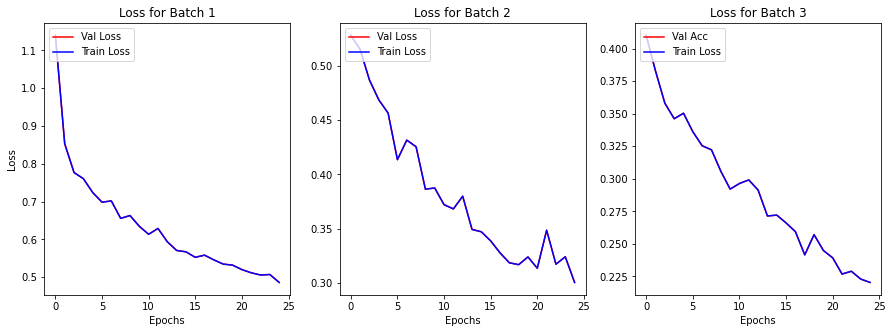

In [34]:
def visualise_train_hist(hist_dict, metric="acc"):
    if metric == "loss":
        y_lbl = "Loss"
        titl = "Loss"
        
        train_met = "bce_dice_loss"
        train_lbl = "Train Loss"
        
        val_met = "bce_dice_loss"
        val_lbl = "Val Loss"
    else:
        y_lbl = "Accuracy"
        titl = "Accuracy"
        
        train_met = "accuracy"
        train_lbl = "Train Acc"
        
        val_met = "val_accuracy"
        val_lbl = "Val Acc"
        
        
    batch_0_hist = hist_dict[0]
    batch_1_hist = hist_dict[1]
    batch_2_hist = hist_dict[2]
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    
    axs[0].plot(batch_0_hist.epoch,batch_0_hist.history[val_met], color="red", label = val_lbl)
    axs[0].plot(batch_0_hist.epoch,batch_0_hist.history[train_met], color="blue", label = train_lbl)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel(y_lbl)
    axs[0].set_title(titl + ' for Batch 1')
    axs[0].legend(loc='upper left')
    
    axs[1].plot(batch_1_hist.epoch,batch_1_hist.history[val_met], color="red", label = val_lbl)
    axs[1].plot(batch_1_hist.epoch,batch_1_hist.history[train_met], color="blue", label = train_lbl)
    axs[1].set_xlabel('Epochs')
    axs[1].set_title(titl + ' for Batch 2')
    axs[1].legend(loc='upper left')
    
    axs[2].plot(batch_2_hist.epoch,batch_2_hist.history[val_met], color="red", label = "Val Acc")
    axs[2].plot(batch_2_hist.epoch,batch_2_hist.history[train_met], color="blue", label = train_lbl)
    axs[2].set_xlabel('Epochs')
    axs[2].set_title(titl + ' for Batch 3')
    axs[2].legend(loc='upper left')

visualise_train_hist(train_hist, metric="loss") # , metric="loss"

In [ ]:
loss, acc = model.evaluate(x_val, y_val, verbose=2)

2022-01-14 21:49:34.565162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
train_hist

NameError: name 'train_hist' is not defined

## Prediction

In [35]:
model

In [247]:
#model.load_weights('./keras.model') 

In [55]:
loss, acc = model.evaluate(x_val, y_val, verbose=2)

1/1 - 0s - loss: 0.2607 - accuracy: 0.8005 - 171ms/epoch - 171ms/step


### Test data

Setting the path to test images. `test_y_loc` is the location where the predicted outputs should be saved.

In [36]:
test_x_loc = "../../data/test_images/"
test_y_loc = "../../data/test_preds/"

Extract the names of the test images and sort them and store them in a list.

In [37]:
test_img_names = sorted([s[:-4] for s in os.listdir(test_x_loc)])

In [38]:
print("Number of test images = ", len(test_img_names))

Number of test images =  112


### Ready the model

If `USE_CURRENT_MODEL` is False, then provide the location of the saved model you want to use in `SAVED_MODEL_LOC`.

In [20]:
TRAINING_SAVE_LOC = "../saved_models/training_24/"

In [21]:
USE_CURRENT_MODEL = False #False
SAVED_MODEL_LOC = TRAINING_SAVE_LOC # "saved_models/training_11/"

In [22]:
SAVED_MODEL_LOC

'../saved_models/training_24/'

In [23]:
if not USE_CURRENT_MODEL:
    model = tf.keras.models.load_model(SAVED_MODEL_LOC,custom_objects={'bce_dice_loss':bce_dice_loss})
    print("Model loaded from ", SAVED_MODEL_LOC)

2022-01-14 21:50:51.669272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-14 21:50:51.669436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model loaded from  ../saved_models/training_24/


### Predict the output and save the mask as .png file

> Indented block



In [39]:
def get_predictions(image_loc, test_img_names):
    y_test = {}
    print("Predicting for {} images".format(len(test_img_names)))
    for i in test_img_names:
        print("Predicting for img",i)
        x_test = np.array(PIL.Image.open(image_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255 #
        x_test = x_test.reshape((1,INPUT_SIZE,INPUT_SIZE,3))
        #x_test_mean = x_test.mean()
        #x_test = x_test - x_test_mean
        y_test[i] = model.predict(x_test, verbose=1)
        del x_test
    return y_test

def create_mask(image_dict):
    y_test_mask = {}
    print("Creating masks for {} predictions".format(len(image_dict)))
    for name, img in image_dict.items():
        pred_mask = tf.argmax(img, axis=3)
        pred_mask= np.uint8(pred_mask[0].numpy())
        y_test_mask[name] = pred_mask
    return y_test_mask
        
def save_mask(mask_dict):
    for name, mask in mask_dict.items():
        im = PIL.Image.fromarray(mask)
        im.save(test_y_loc + name + '.png')
        print("Image saved: ", test_y_loc + name + '.png')

preds = get_predictions(test_x_loc,test_img_names)
masks = create_mask(preds)
save_mask(masks)



Predicting for 112 images
Predicting for img 10170
1/1 [==============================] - 0s 191ms/step


2022-01-14 23:28:01.370183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Predicting for img 10171
1/1 [==============================] - 0s 12ms/step
Predicting for img 10184
1/1 [==============================] - 0s 11ms/step
Predicting for img 10566
1/1 [==============================] - 0s 11ms/step
Predicting for img 10808
1/1 [==============================] - 0s 13ms/step
Predicting for img 10812
1/1 [==============================] - 0s 13ms/step
Predicting for img 6413
1/1 [==============================] - 0s 14ms/step
Predicting for img 6424
1/1 [==============================] - 0s 12ms/step
Predicting for img 6427
1/1 [==============================] - 0s 11ms/step
Predicting for img 6450
1/1 [==============================] - 0s 12ms/step
Predicting for img 6455
1/1 [==============================] - 0s 12ms/step
Predicting for img 6457
1/1 [==============================] - 0s 11ms/step
Predicting for img 6459
1/1 [==============================] - 0s 12ms/step
Predicting for img 6462
1/1 [==============================] - 0s 11ms/step
Predict

1/1 [==============================] - 0s 11ms/step
Predicting for img 9110
1/1 [==============================] - 0s 11ms/step
Predicting for img 9723
1/1 [==============================] - 0s 11ms/step
Predicting for img 9795
1/1 [==============================] - 0s 11ms/step
Creating masks for 112 predictions
Image saved:  ../../data/test_preds/10170.png
Image saved:  ../../data/test_preds/10171.png
Image saved:  ../../data/test_preds/10184.png
Image saved:  ../../data/test_preds/10566.png
Image saved:  ../../data/test_preds/10808.png
Image saved:  ../../data/test_preds/10812.png
Image saved:  ../../data/test_preds/6413.png
Image saved:  ../../data/test_preds/6424.png
Image saved:  ../../data/test_preds/6427.png
Image saved:  ../../data/test_preds/6450.png
Image saved:  ../../data/test_preds/6455.png
Image saved:  ../../data/test_preds/6457.png
Image saved:  ../../data/test_preds/6459.png
Image saved:  ../../data/test_preds/6462.png
Image saved:  ../../data/test_preds/6463.png
Imag

### Saving the output for kaggle submission

In [40]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles(test_pred_dir):
    """Used for Kaggle submission: predicts and encode all test images"""
    N = len([i for i in list(os.listdir(test_pred_dir)) if i[-3:] == "png"])
    with open('../submissions/submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(test_pred_dir)):
            if i[-3:] == "png":
                print('Saving {}/{}'.format(index, N))
                mask = PIL.Image.open(test_pred_dir + i)
                mask = mask.resize((1024, 1024), resample= PIL.Image.NEAREST)
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles(test_y_loc) 

Saving 0/112
Saving 1/112
Saving 2/112
Saving 3/112
Saving 4/112
Saving 5/112
Saving 6/112
Saving 7/112
Saving 8/112
Saving 9/112
Saving 10/112
Saving 11/112
Saving 12/112
Saving 13/112
Saving 14/112
Saving 15/112
Saving 16/112
Saving 17/112
Saving 18/112
Saving 19/112
Saving 20/112
Saving 21/112
Saving 22/112
Saving 23/112
Saving 24/112
Saving 25/112
Saving 26/112
Saving 27/112
Saving 28/112
Saving 29/112
Saving 30/112
Saving 31/112
Saving 32/112
Saving 33/112
Saving 34/112
Saving 35/112
Saving 36/112
Saving 37/112
Saving 38/112
Saving 39/112
Saving 40/112
Saving 41/112
Saving 42/112
Saving 43/112
Saving 44/112
Saving 45/112
Saving 46/112
Saving 47/112
Saving 48/112
Saving 49/112
Saving 50/112
Saving 51/112
Saving 52/112
Saving 53/112
Saving 54/112
Saving 55/112
Saving 56/112
Saving 57/112
Saving 58/112
Saving 59/112
Saving 60/112
Saving 61/112
Saving 62/112
Saving 63/112
Saving 64/112
Saving 65/112
Saving 66/112
Saving 67/112
Saving 68/112
Saving 69/112
Saving 70/112
Saving 71/112
Sa

## Making a kaggle submission

Make sure you have installed the kaggle package and completed all the steps listed here : https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953

In [221]:
!kaggle competitions submit -c fdl21-fdl-dsba -f submissions/submission_file.csv -m "batch 87 change t20 m0"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


## Visualise the output of the model prediction

Predicting for 1 images
Predicting for img 6456
1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating masks for 1 predictions
dict_keys(['6456'])


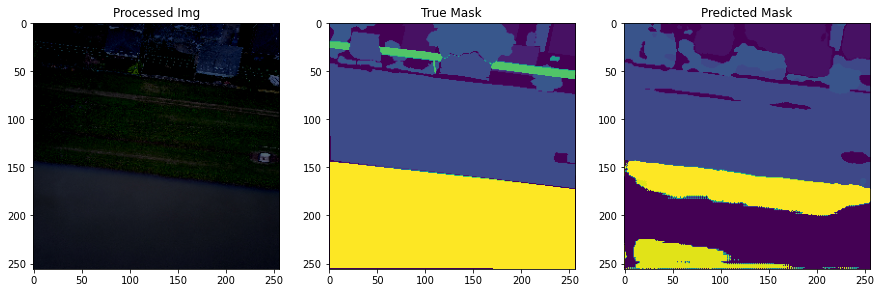

In [262]:
def visualise_test(image_name):

    img1 = np.array(PIL.Image.open(test_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    img2 = mpimg.imread(test_y_loc + image_name +'.png')
    # mpimg.imread(test_x_loc + '6413.jpg')

    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('Predicted img')
    
def visualise_train(image_name):

    img1 = np.array(PIL.Image.open(train_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    #img1_mean = img1.mean()
    #img1 = img1 - img1_mean
    img2 = np.array(PIL.Image.open(train_y_loc + image_name + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))
    # mpimg.imread(train_y_loc + image_name +'.png')
    # mpimg.imread(test_x_loc + '6413.jpg')

    img_name = [image_name]
    pred = get_predictions(train_x_loc,img_name)
    mask = create_mask(pred)
    print(mask.keys())
    img3 = mask[image_name]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('True Mask')
    axs[2].imshow(img3)
    axs[2].set_title('Predicted Mask')
    
assert(model is not None)
# visualise_test('') # provide only image names from 'test_images'
visualise_train('6456') # provide only image names from 'train_images'